<a href="https://colab.research.google.com/github/eldhosejoseph/thesis/blob/main/BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Links:

Thesis
======
Lit Rev. doc:

https://essexuniversity-my.sharepoint.com/:w:/g/personal/ej23373_essex_ac_uk/ETT7lRYeuXtPtblJcIEk8RoBCZQh4n3iwu6D9PdIGTfqIg?e=85Tcdg

Lit Rev. excel

https://essexuniversity-my.sharepoint.com/:x:/g/personal/ej23373_essex_ac_uk/EcJZ_XBNmeJDnpupWDcv3d8BSXQg_tGeqG7sapKg2hQPsQ?e=VfMMKz

Link doc

https://essexuniversity-my.sharepoint.com/:w:/g/personal/ej23373_essex_ac_uk/Ec8YxFG32FJJsTI_q4_fxZkBXSzl8kM7KdRIbC3ODjDmHg?e=UGIrrR


Thesis meeting link

https://essexuniversity-my.sharepoint.com/:w:/r/personal/ej23373_essex_ac_uk/_layouts/15/Doc.aspx?sourcedoc=%7B643F9DC8-2E85-4125-B005-BACF65A8209B%7D&file=Thesis-Term3-Meeting%20Notes.docx&action=default&mobileredirect=true&DefaultItemOpen=1&login_hint=ej23373%40essex.ac.uk&ct=1718975916814&wdOrigin=OFFICECOM-WEB.MAIN.REC&cid=4861056d-f36b-4977-b756-b9b5e94250e8&wdPreviousSessionSrc=HarmonyWeb&wdPreviousSession=4500332f-d0be-48f2-b358-b1a4a32a7b84

**Dataset**

An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Paper: https://www.nature.com/articles/s41597-024-03234-y :An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Pre-print: https://assets-eu.researchsquare.com/files/rs-2521275/v1_covered.pdf?c=1676412896

Supplementary Files: https://assets-eu.researchsquare.com/files/rs-2521275/v1/ee537dc92ed9e0bcb9e4ca87.pdf

Dataset: https://figshare.com/articles/dataset/An_EEG_Dataset_of_Neural_Signatures_in_a_Competitive_Two-Player_Game_Encouraging_Deceptive_Behavior/24760827/3

git: https://github.com/yiyuchen-lab/DeceptionGame


# Libraries and Packages

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.7 MB/s eta 0:00:00


In [2]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.1 MB/s eta 0:00:00


In [3]:
import mne
import os
import re
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np
import pandas as pd
import os
import re
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix
from mne.decoding import CSP
from scipy.fft import fft
from scipy.linalg import eigh
import ast
import pywt
from sklearn.feature_selection import f_classif


In [5]:
from scipy.signal import welch

# Dataset Import [Competitive Two Player Game- Deception Task]

In [6]:
###2d
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def eegfiles(n):

    def get_filtered_files(folder_path):
        # Regular expression pattern to match the required file format
        pattern = re.compile(r'Player_(sub\d+)_Observer_(sub\d+)\.mat')

        # Dictionary to store the filtered files
        filtered_files = {}

        # Check if the folder exists
        if not os.path.isdir(folder_path):
            print(f"The folder '{folder_path}' does not exist.")
            return filtered_files

        # Iterate over files in the specified folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.mat'):
                match = pattern.match(filename)
                if match:
                    player_id = match.group(1)
                    p_key = f"p{int(player_id[3:])}"  # Convert subXX to pX
                    if p_key not in filtered_files:
                        filtered_files[p_key] = []
                    # Store the file path in the dictionary
                    filtered_files[p_key].append(os.path.join(folder_path, filename))

        return filtered_files

    def get_key_list(filtered_files):
        # Return the list of keys
        return list(filtered_files.keys())

    def get_specific_files(filtered_files, key):
        # Return the list of files for the specified key
        return filtered_files.get(key, [])

    # Specify the folder containing the .txt files
    folder_path = '//content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking'

    # Get the filtered files
    filtered_files = get_filtered_files(folder_path)

    # Get the list of keys
    keys = get_key_list(filtered_files)

    # Print the list of keys
    #print("List of keys:", keys)

    # Get specific files for a key, e.g., p1
    keys = [f'p{i}' for i in range(1, 25) if i != 2]
    key_to_retrieve = keys[n]
    specific_files = get_specific_files(filtered_files, key_to_retrieve)

    # Print the files for the specified key
    #print(f"\nFiles for {key_to_retrieve}:")
    for file in specific_files:
        #print(f"  {file}")
        return  file

In [8]:
# Define options
opt = {
    'preprocessedData_path': '/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking',
    'epoch_type': ['DecisionMaking'],
    'session_role': ['player','observer'],
    'eegmarker_label': {
        'showCard': ['sponL', 'sponT', 'instL', 'instT']
    }
}

# Load data
data_path = os.path.join(opt['preprocessedData_path'], opt['epoch_type'][0])

files=[]
for n in range(23):
  files.append(eegfiles(n))

filenames = [f for f in files if f.endswith('.mat')]
epos = []
for file in filenames:
    mat = sio.loadmat(os.path.join(data_path, file))
    epos.append(mat[opt['session_role'][0]])

# ERP ANALYSIS

In [ ]:
player=0
mode=1  #0-100, 1-eeg, 2-channel name, 3-sample, 4-cards, 5-timestamp 6-player name set
cardsample=1  #0-sponL, 1-sponT, 2-instL, 3-instT
channelnum=1
epos[player][0][0][mode][349][0][0]

-0.4117603003978729

In [ ]:
#data
player=0
channelnum=1
cardsample=1

#eeg
mode=1
channel_num=0
trial=0
eeg=epos[player][0][0][mode][0][channel_num][trial]

#channel names
mode=2
ch_names=epos[player][0][0][mode][0]

#sample
mode=3
card_category=0    #0-sponL, 1-sponT, 2-instL, 3-instT
trial=0 #44 trials * 11 =484 trials
samples=epos[player][0][0][mode]  #4 sample category sublist
samples_cat=samples[card_category]
samples_trial=samples_cat[trial]

#cards
mode=4
cards=epos[player][0][0][mode][0]

#timestamp
mode=5
timestamps=epos[player][0][0][mode][0]

#player name set
mode=6
player_name=epos[player][0][0][mode][0]

In [ ]:
ch_names

array([array(['F7'], dtype='<U2'), array(['F3'], dtype='<U2'),
       array(['Fz'], dtype='<U2'), array(['F4'], dtype='<U2'),
       array(['F8'], dtype='<U2'), array(['FC5'], dtype='<U3'),
       array(['FC1'], dtype='<U3'), array(['FC2'], dtype='<U3'),
       array(['FC6'], dtype='<U3'), array(['T7'], dtype='<U2'),
       array(['C3'], dtype='<U2'), array(['Cz'], dtype='<U2'),
       array(['C4'], dtype='<U2'), array(['T8'], dtype='<U2'),
       array(['CP5'], dtype='<U3'), array(['CP1'], dtype='<U3'),
       array(['CP2'], dtype='<U3'), array(['CP6'], dtype='<U3'),
       array(['P7'], dtype='<U2'), array(['P3'], dtype='<U2'),
       array(['Pz'], dtype='<U2'), array(['P4'], dtype='<U2'),
       array(['P8'], dtype='<U2'), array(['PO3'], dtype='<U3'),
       array(['PO4'], dtype='<U3'), array(['O1'], dtype='<U2'),
       array(['O2'], dtype='<U2'), array(['F9'], dtype='<U2'),
       array(['F10'], dtype='<U3'), array(['Fp2'], dtype='<U3')],
      dtype=object)

In [9]:
def player_df(player):
    # Data extraction based on the provided indices and modes
    # Extract EEG data for each trial
    eeg_data = epos[player][0][0][1]

    # Extract channel names
    ch_names = epos[player][0][0][2][0]

    # Extract samples (trial categories)
    samples = epos[player][0][0][3]

    # Extract cards (round and trial data)
    cards = epos[player][0][0][4][0]

    # Extract timestamps
    timestamps = epos[player][0][0][5][0]

    # Create an empty list to store the rows of the dataframe
    data_rows = []

    # Number of rounds and trials per round
    num_rounds = 11
    trials_per_round = 44

    # Map sample indices to categories
    sample_to_category = {0: 'sponL', 1: 'sponT', 2: 'instT', 3: 'instL'}  #changed here

    # Loop through the rounds and trials to create rows for the dataframe
    for r in range(num_rounds):
        for t in range(trials_per_round):
            # Calculate the overall trial index
            trial_index = r * trials_per_round + t

            # Check if trial_index is within bounds
            if trial_index >= len(samples[0]):
                continue

            # Determine the category for the current trial
            category = None
            for cat_index, trials in enumerate(samples):
                if trials[trial_index] == 1:
                    category = sample_to_category[cat_index]
                    break

            # Create a row for the dataframe
            row = [r+1, t+1, category]

            # Append EEG data for each channel to the row as a list of values
            for ch in range(30):
                channel_data = [eeg_data[i][ch][trial_index] for i in range(350)]
                row.append(channel_data)

            # Append the row to the list of data rows
            data_rows.append(row)

    # Create column names
    column_names = ['round', 'trial', 'category'] + [f'channel_{i}' for i in range(1,31)]

    # Create the dataframe
    df = pd.DataFrame(data_rows, columns=column_names)

    return df

def grand_average(channel_num):
  if channel_num in range(1,31):
      all_players_data = []

      # Iterate through all players and gather their data
      for p in range(len(epos)):
          df = player_df(p)
          all_players_data.append(df)

      # Combine all players' data into one DataFrame
      combined_df = pd.concat(all_players_data, ignore_index=True)

      # Initialize a dictionary to hold the grand average for each category
      grand_averages = {'sponL': [], 'sponT': [], 'instL': [], 'instT': []}

      # Calculate the grand average for each category
      for category in grand_averages.keys():
          category_data = combined_df[combined_df['category'] == category]

          # Collect all EEG lists for the specified channel across all trials for the current category
          all_eeg_lists = np.array(category_data[f'channel_{channel_num}'].tolist())

          # Calculate the grand average by taking the mean across the first dimension (trials)
          grand_averages[category] = np.mean(all_eeg_lists, axis=0)
  return grand_averages

def plot_erp(channel_num):
    if channel_num in range(1,31):
      grand_averages=grand_average(channel_num)

      # Extract timestamps
      timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

      # Define the range for x-axis in milliseconds
      x_range = (-100, 700)
      timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

      # Filter the timestamps and grand averages to include only the desired range
      valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

      # Plot the grand averages
      plt.figure(figsize=(10, 6))
      color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
      for category, data in grand_averages.items():
          #plt.plot(data, label=category)
          plt.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

      plt.title(f'Grand Average ERP for Channel {channel_num}[{ch_names[channel_num-1][0]}]')
      plt.xlabel('Time Points')
      plt.ylabel('EEG Amplitude')
      plt.legend()
      plt.grid(True)
      plt.show()

    else:
      print('Channel Num range: [1,30]')

In [ ]:
player_df(0)

round  trial category                                          channel_1  \
0        1      1    instL  [-7.187648296356201, -5.544002532958984, -7.35...   
1        1      2    instT  [1.2291985750198364, -1.5544863939285278, -0.1...   
2        1      3    sponL  [1.816788673400879, -3.5158941745758057, -2.98...   
3        1      4    sponT  [0.5361368060112, -1.0909773111343384, 4.22203...   
4        1      5    sponT  [-0.029911193996667862, -3.1370058059692383, -...   
..     ...    ...      ...                                                ...   
479     11     40    instL  [6.117779731750488, 10.96666431427002, 1.32373...   
480     11     41    instL  [3.6983792781829834, 3.71504545211792, 0.32541...   
481     11     42    sponT  [-0.0317998006939888, -5.558475971221924, -6.6...   
482     11     43    instT  [0.007146023213863373, -2.2718169689178467, -1...   
483     11     44    sponT  [4.386919021606445, -0.1182846650481224, 1.514...   

                                             channel_2  \
0    [-6.718522548675537, -6.300747871398926, -5.67...   
1    [1.2249093055725098, -0.5782337784767151, -2.9...   
2    [2.8654603958129883, 0.5553973913192749, 0.081...   
3    [0.3963924050331116, -3.21319580078125, -4.007...   
4    [2.6598122119903564, 1.0699927806854248, 2.663...   
..                                                 ...   
479  [1.397680640220642, 2.1269638538360596, -0.001...   
480  [-4.883649826049805, -7.849109649658203, 0.388...   
481  [0.7314388751983643, -3.714141368865967, 1.811...   
482  [1.4297032356262207, 0.615843653678894, 0.9495...   
483  [6.396651744842529, 2.658174514770508, -4.2287...   

                                             channel_3  \
0    [-5.539710998535156, -4.659396648406982, -4.15...   
1    [-1.2387791872024536, -2.4554600715637207, -0....   
2    [7.664554595947266, 1.350868582725525, 1.31465...   
3    [-2.851555585861206, -0.7630741596221924, -1.5...   
4    [-0.7059302926063538, 1.0232218503952026, 2.61...   
..                                                 ...   
479  [-1.8392326831817627, 0.046885862946510315, 1....   
480  [-3.159782886505127, -4.61883544921875, -2.245...   
481  [0.8116948008537292, -4.831766128540039, -0.89...   
482  [-1.5802072286605835, -2.757807970046997, 0.90...   
483  [4.8692545890808105, 3.0096797943115234, -1.28...   

                                             channel_4  \
0    [-0.7264593243598938, -7.186114311218262, -9.6...   
1    [-4.656713962554932, -1.7271572351455688, -0.6...   
2    [12.64748477935791, 0.4301597476005554, -3.986...   
3    [-8.88652515411377, 1.542443037033081, -13.135...   
4    [-1.2520992755889893, 0.5941079258918762, 4.19...   
..                                                 ...   
479  [-4.370779514312744, -2.5312612056732178, 6.12...   
480  [-5.544626712799072, -3.9740843772888184, 9.43...   
481  [-5.158082008361816, -4.654942035675049, 0.863...   
482  [2.9718401432037354, -7.324542045593262, 3.359...   
483  [-2.0694420337677, 2.376873254776001, -3.59780...   

                                             channel_5  \
0    [6.909163475036621, 6.7908148765563965, 6.2678...   
1    [-6.363761901855469, -1.6117775440216064, 2.77...   
2    [1.1349503993988037, -0.7638134360313416, -0.0...   
3    [2.1866707801818848, 2.437052011489868, 5.1909...   
4    [6.521529197692871, 3.7668473720550537, 3.6134...   
..                                                 ...   
479  [3.540809154510498, 6.6174774169921875, -1.073...   
480  [10.275787353515625, 2.429325580596924, 3.0677...   
481  [-5.64825963973999, -3.8080334663391113, -1.73...   
482  [7.3113884925842285, 5.312363147735596, -1.912...   
483  [0.2574600577354431, -1.8381143808364868, 2.95...   

                                             channel_6  \
0    [-4.523265838623047, -3.364429473876953, -0.88...   
1    [5.150352954864502, 2.263970136642456, 0.46210...   
2    [2.5281596183776855, 2.4894180297851562, -1.49...   
3    [0.0205

In [ ]:
#grand_average(0)

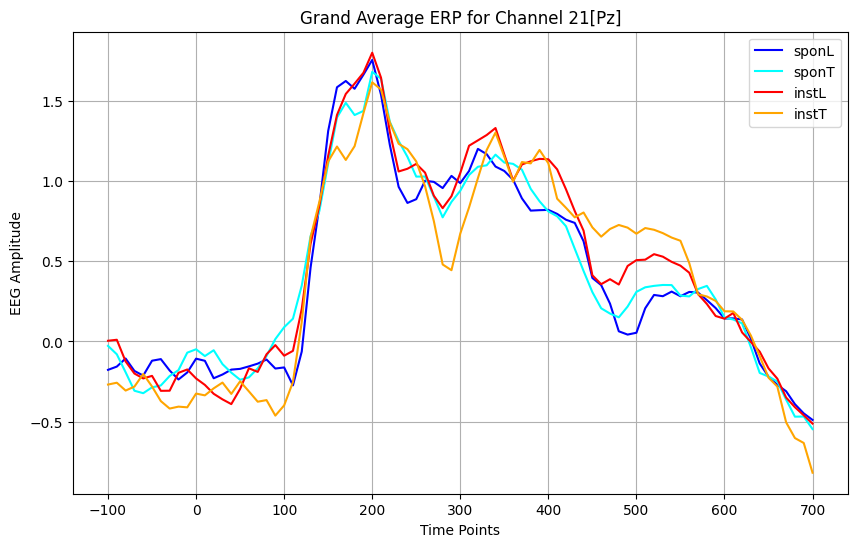

In [ ]:
plot_erp(21)

In [ ]:
def plot_all_channels():
    # Extract timestamps
    timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

    # Define the range for x-axis in milliseconds
    x_range = (-100, 700)
    timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

    # Filter the timestamps to include only the desired range
    valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

    # Create subplots
    fig, axs = plt.subplots(6, 5, figsize=(20, 20))
    fig.suptitle('Grand Average ERP for All Channels')

    for channel_num in range(1, 31):
        grand_averages = grand_average(channel_num)

        row = (channel_num - 1) // 5
        col = (channel_num - 1) % 5
        ax = axs[row, col]

        color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
        for category, data in grand_averages.items():
            ax.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

        ax.set_title(f'Channel {channel_num} [{ch_names[channel_num-1][0]}]')
        ax.set_xlabel('Time Points (ms)')
        ax.set_ylabel('EEG Amplitude')
        ax.legend()
        ax.grid(True)
        if channel_num == 1:
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#plot_all_channels()


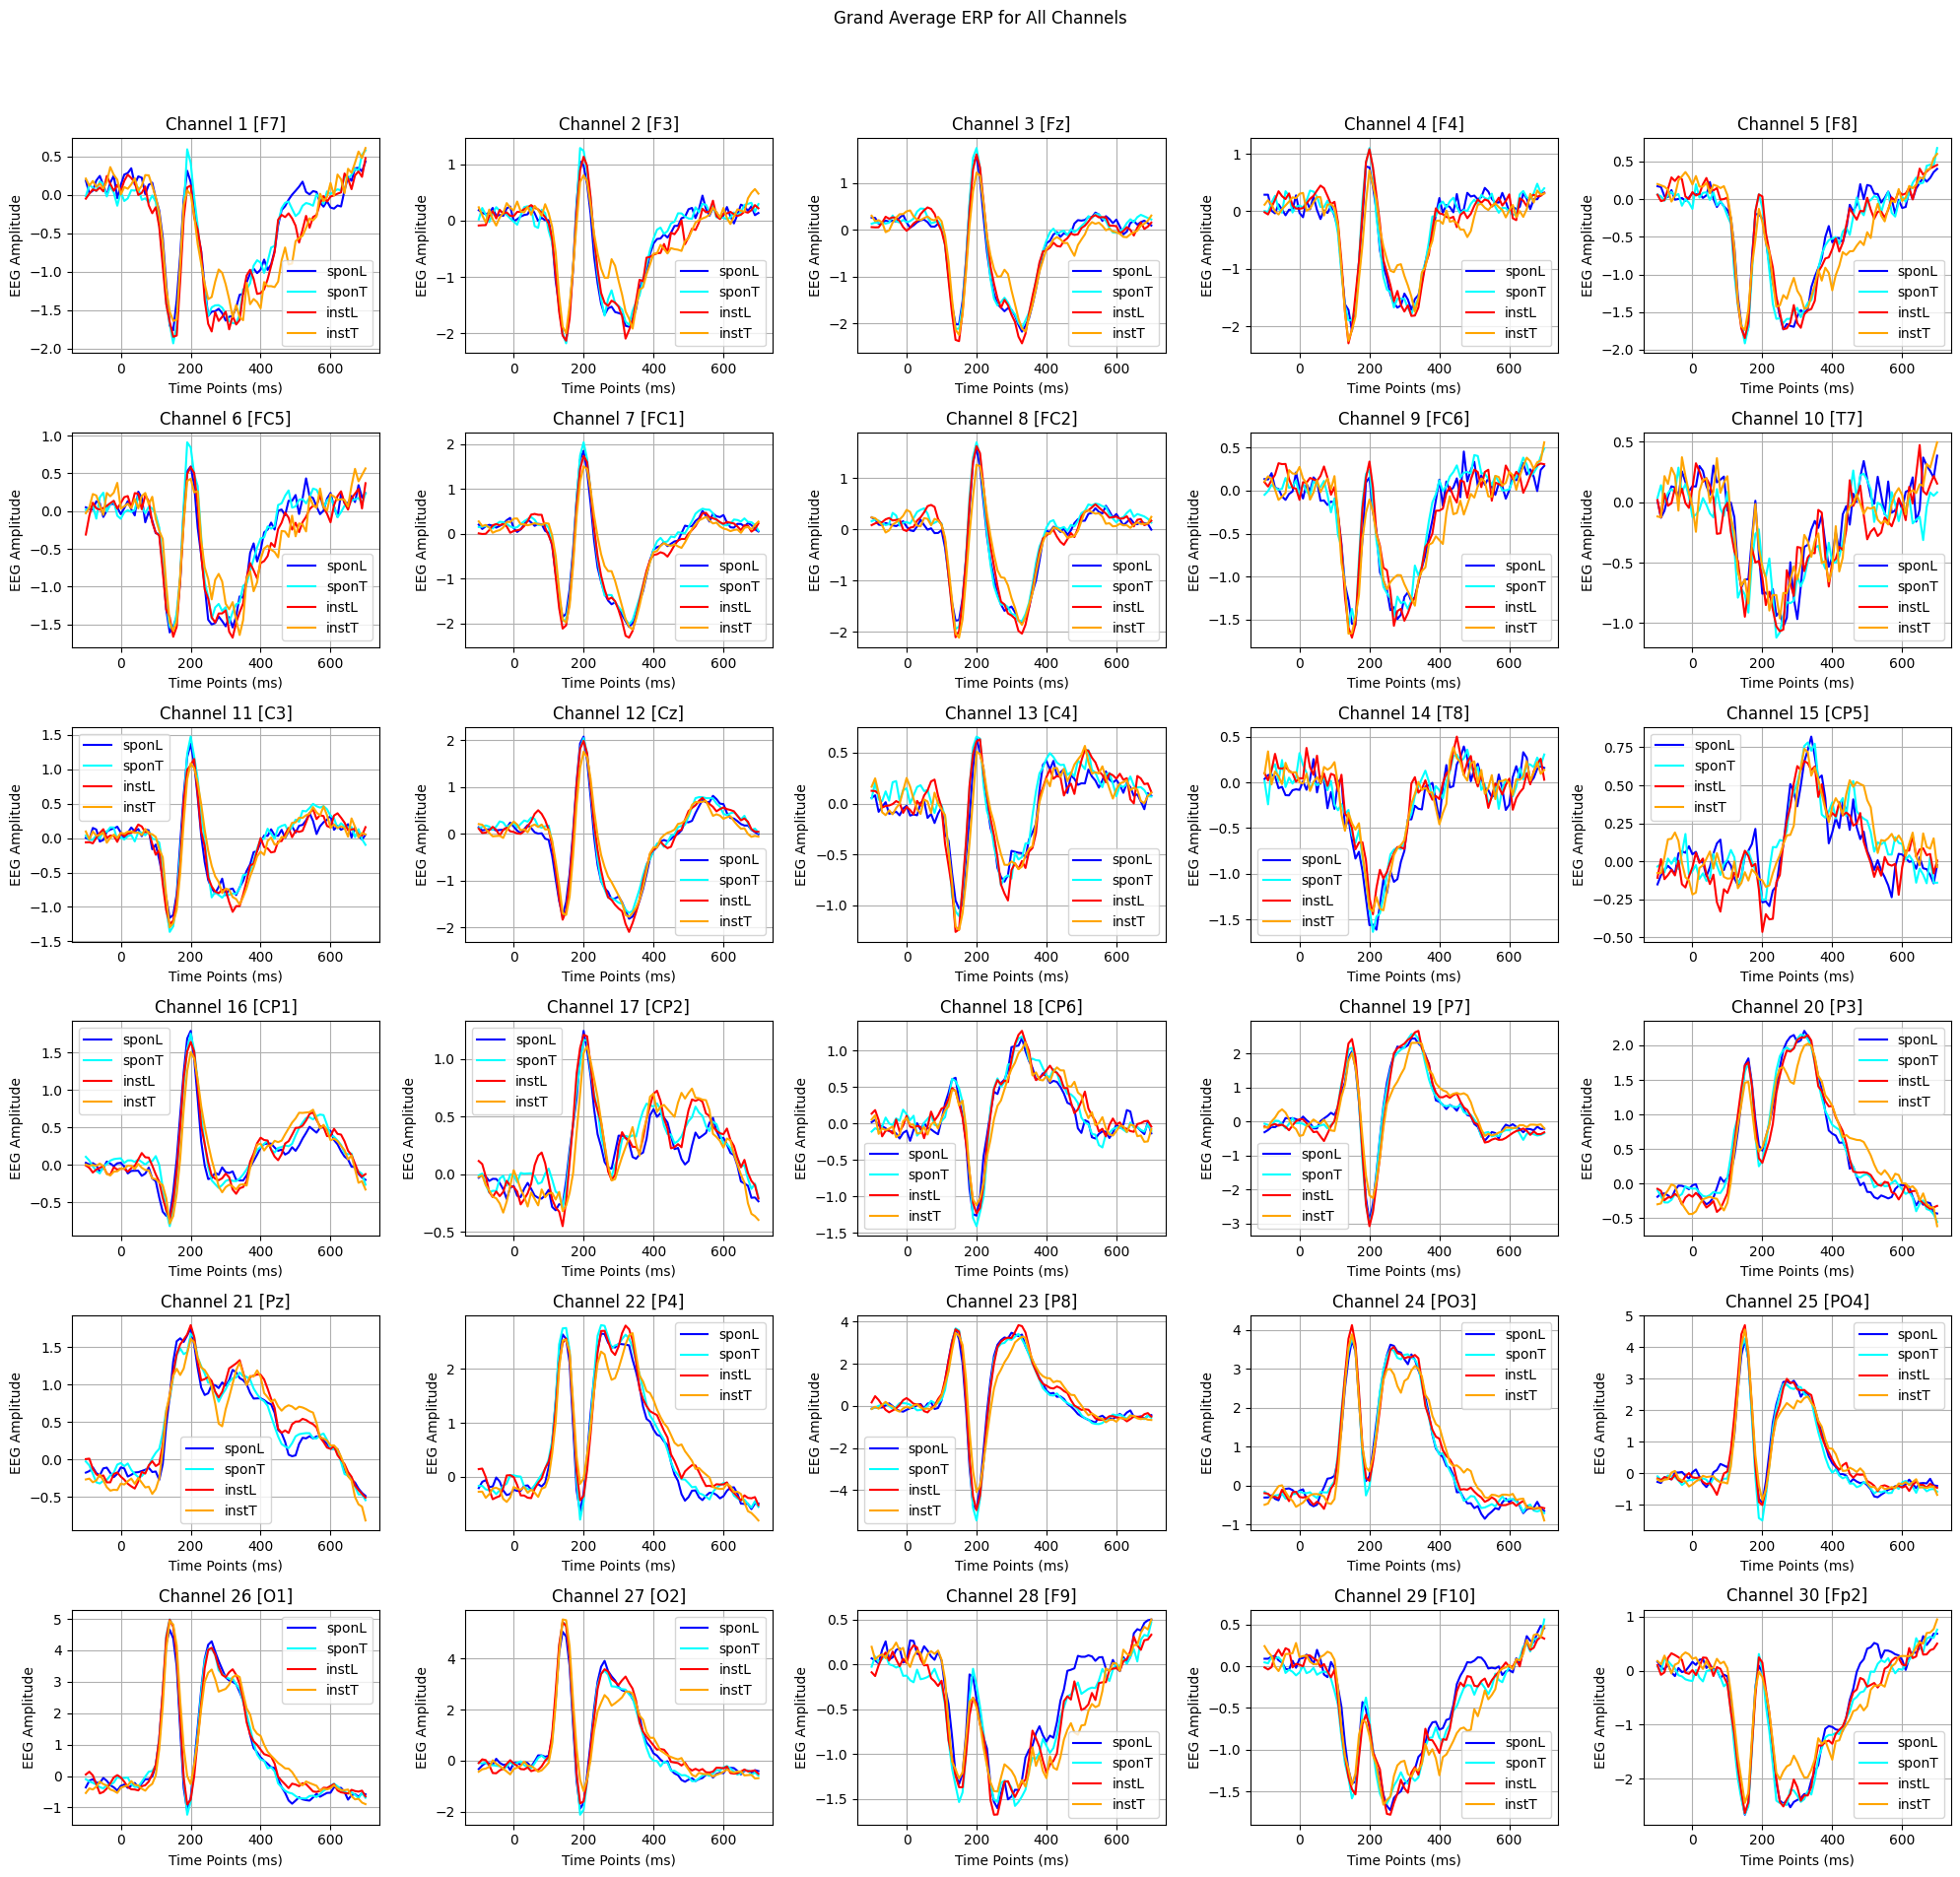

# DATASET CREATION

In [16]:
def dataset(channel_num):
  eeg=[]
  category=[]
  for player in range(23):
    df=player_df(player)
    category.append(df[df.columns[2]].values)
    eeg.append(df[df.columns[channel_num+2]].values)

  data={'x':eeg, 'y':category}
  return pd.DataFrame(data)

# Function to expand the DataFrame
def expand_dataframe(df):
    expanded_rows = []
    for player in range(23):  # Iterate over each player
      if player==19:trials=483
      elif player==21:trials=482
      else:trials=484
      for trial in range(trials):  # Iterate over each trial (484 trials)
            x_values = df.iloc[player, 0][trial]  # Extract the list of 350 values
            y_value = df.iloc[player, 1][trial]   # Extract the corresponding y value
            expanded_rows.append({'x': x_values, 'y': y_value})
    return pd.DataFrame(expanded_rows)

In [17]:
channel=21 #channel: 1 to 30
expand_dataframe(dataset(channel))

x      y
0      [1.322716236114502, 2.994771718978882, 6.41149...  instL
1      [-3.844251871109009, -3.7300541400909424, -2.4...  instT
2      [-4.691122531890869, -1.633573293685913, -0.56...  sponL
3      [3.3362035751342773, 5.152755260467529, 4.7315...  sponT
4      [0.20543311536312103, -0.11058960109949112, -2...  sponT
...                                                  ...    ...
11124  [2.688664436340332, 5.636557102203369, 3.92807...  instL
11125  [-0.6962383389472961, 1.46507728099823, -2.223...  instL
11126  [-3.8817899227142334, 0.4896158277988434, 0.76...  sponT
11127  [-0.06153459846973419, -3.9250741004943848, -1...  sponT
11128  [4.467114448547363, 3.1150472164154053, 1.7452...  instT

[11129 rows x 2 columns]

In [18]:
player=0
ch_names=epos[player][0][0][2][0]

In [19]:
ch_names

array([array(['F7'], dtype='<U2'), array(['F3'], dtype='<U2'),
       array(['Fz'], dtype='<U2'), array(['F4'], dtype='<U2'),
       array(['F8'], dtype='<U2'), array(['FC5'], dtype='<U3'),
       array(['FC1'], dtype='<U3'), array(['FC2'], dtype='<U3'),
       array(['FC6'], dtype='<U3'), array(['T7'], dtype='<U2'),
       array(['C3'], dtype='<U2'), array(['Cz'], dtype='<U2'),
       array(['C4'], dtype='<U2'), array(['T8'], dtype='<U2'),
       array(['CP5'], dtype='<U3'), array(['CP1'], dtype='<U3'),
       array(['CP2'], dtype='<U3'), array(['CP6'], dtype='<U3'),
       array(['P7'], dtype='<U2'), array(['P3'], dtype='<U2'),
       array(['Pz'], dtype='<U2'), array(['P4'], dtype='<U2'),
       array(['P8'], dtype='<U2'), array(['PO3'], dtype='<U3'),
       array(['PO4'], dtype='<U3'), array(['O1'], dtype='<U2'),
       array(['O2'], dtype='<U2'), array(['F9'], dtype='<U2'),
       array(['F10'], dtype='<U3'), array(['Fp2'], dtype='<U3')],
      dtype=object)

# Statistical Test for difference

In [ ]:
def plot_channel_boxplot(df, channel_number):
    """
    Plot a box plot of EEG values for a specific channel, categorized by label.

    Parameters:
    - df: DataFrame with columns 'x' (list of EEG values) and 'y' (labels).
    - channel_number: Integer, the channel number to analyze (1-based index).

    Returns:
    - None: Displays a box plot with different colors for each label.
    """
    if channel_number < 1 or channel_number > 30:
        raise ValueError("Channel number must be between 1 and 30.")
    else:
      # Ensure that 'x' is a list of lists
      if not isinstance(df['x'].iloc[0], list):
          raise ValueError("'x' column must contain lists of EEG values.")

      # Convert 1-based index to 0-based index
      channel_index = channel_number - 1

      # Check if channel_index is within the range of EEG data
      if any(len(x) <= channel_index for x in df['x']):
          raise ValueError(f"Channel number {channel_number} is out of range for some EEG data.")

      # Extract EEG values for the specified channel
      df['channel_value'] = df['x'].apply(lambda x: x[channel_index])

      # Prepare data for plotting
      grouped_data = df.groupby('y')['channel_value'].apply(list)

      # Create a box plot
      plt.figure(figsize=(10, 6))

      # Plot boxplot
      plt.boxplot(grouped_data, labels=grouped_data.index, patch_artist=True)

      # Customize plot
      plt.xlabel('Labels')
      plt.ylabel(f'EEG Values for Channel {channel_number}')
      plt.title(f'Box Plot of EEG Values for Channel {channel_number} by Label')
      plt.grid(True)
      plt.show()



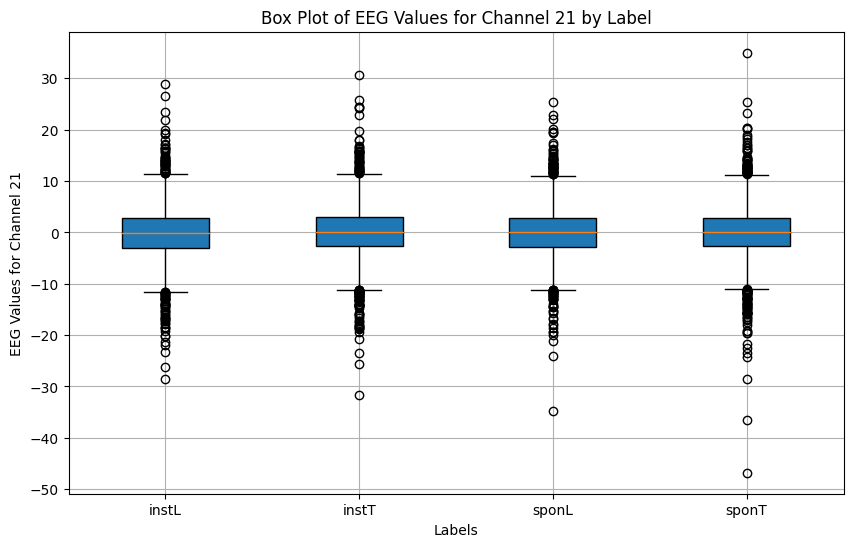

In [ ]:
df=expand_dataframe(dataset(channel))
channel_number=21
plot_channel_boxplot(df, channel_number)

In [14]:
def p300_df(df):
    def time_window(l,u):
          # Extract timestamps
          timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

          # Define the range for x-axis in milliseconds
          x_range = (l, u)
          timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

          # Filter the timestamps to include only the desired range
          valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

          return valid_indices

    def eeg_window(eeg, timewindow):
        eeg=[eeg[i] for i in time_window(timewindow[0],timewindow[1])]
        return eeg


    def mean(list):
      mean=sum(list)/len(list)
      return mean

    def erp_time_window(eeg_df, time_window):
      #eeg_df=dataset(channel_num)
      x=eeg_df['x']
      y=eeg_df['y']
      x_new=[]
      for i in range(len(x)):
        x_new.append((eeg_window(x[i],time_window)))

      eeg_df_n=pd.DataFrame({'x':x_new, 'y':y})
      return eeg_df_n

    return erp_time_window(df, [250, 500])

In [ ]:
p300_df(expand_dataframe(dataset(21)))

x      y
0      [-0.3757180869579315, 1.5885050296783447, 0.53...  instL
1      [-2.4870445728302, 4.088906764984131, 3.310979...  instT
2      [-4.7962517738342285, -1.4890989065170288, -1....  sponL
3      [-6.236530303955078, -6.72092342376709, -5.495...  sponT
4      [-2.0842483043670654, -1.3741694688796997, 1.1...  sponT
...                                                  ...    ...
11124  [-0.2080729752779007, -1.6513162851333618, -1....  instL
11125  [-2.7477426528930664, -0.6444938778877258, -1....  instL
11126  [-3.3445396423339844, 0.36243292689323425, -0....  sponT
11127  [-0.43944233655929565, -2.3280997276306152, -5...  sponT
11128  [-2.0203769207000732, -2.375077247619629, -1.8...  instT

[11129 rows x 2 columns]

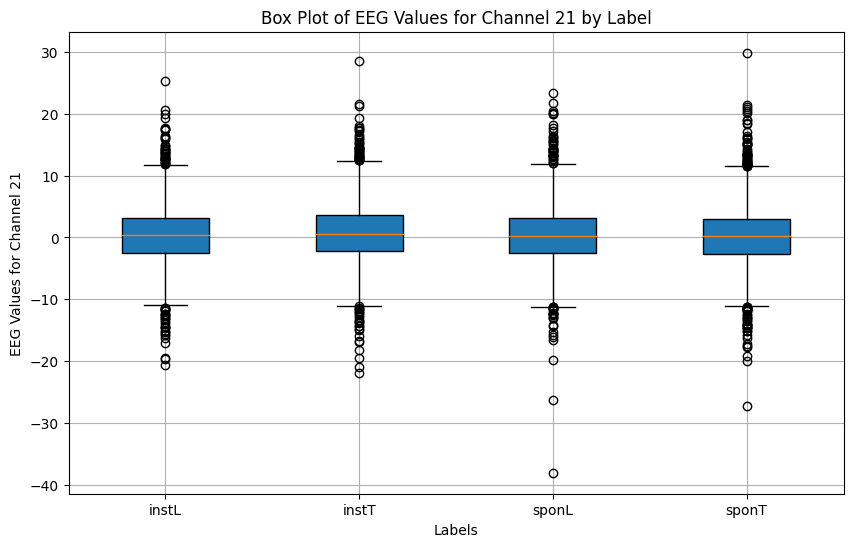

In [ ]:
df=p300_df(expand_dataframe(dataset(channel)))
channel_number=21
plot_channel_boxplot(df, channel_number)

In [ ]:
import seaborn as sns

def plot_distribution_of_means(df):
    # Calculate the mean of each row in the 'x' column
    df['x_mean'] = df['x'].apply(np.mean)

    # Plot the distribution of means for each category in 'y'
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='x_mean', hue='y', kde=True, bins=30)
    plt.title('Distribution of Means for Each Category')
    plt.xlabel('Mean of x')
    plt.ylabel('Density')
    plt.show()

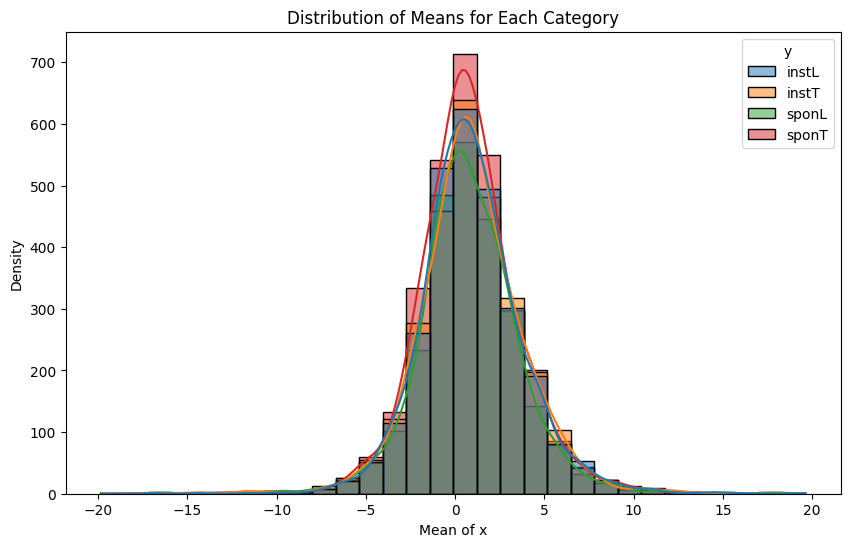

In [ ]:
channel_num=21
# Plot the distribution of means for each category
plot_distribution_of_means(p300_df(expand_dataframe(dataset(channel_num))))

In [ ]:
from scipy.stats import shapiro

def check_normality(df):
    df['x_mean'] = df['x'].apply(np.mean)
    results = {}

    for category in df['y'].unique():
        data = df[df['y'] == category]['x_mean']
        stat, p_value = shapiro(data)
        results[category] = {'statistic': stat, 'p_value': p_value}

    # Output normality test results
    for category, result in results.items():
        print(f"Category: {category}, Shapiro-Wilk Test Statistic: {result['statistic']:.4f}, p-value: {result['p_value']:.4f}")
        if result['p_value'] < 0.05:
            print(f"Data in category {category} seems to be normally distributed (reject H0).")
        else:
            print(f"Data in category {category} does not seem to be normally distributed (fail to reject H0).")


In [ ]:
channel_num=21
# Check normality for each category
check_normality(p300_df(expand_dataframe(dataset(channel_num))))

Category: instL, Shapiro-Wilk Test Statistic: 0.9709, p-value: 0.0000
Data in category instL seems to be normally distributed (reject H0).
Category: instT, Shapiro-Wilk Test Statistic: 0.9672, p-value: 0.0000
Data in category instT seems to be normally distributed (reject H0).
Category: sponL, Shapiro-Wilk Test Statistic: 0.9629, p-value: 0.0000
Data in category sponL seems to be normally distributed (reject H0).
Category: sponT, Shapiro-Wilk Test Statistic: 0.9743, p-value: 0.0000
Data in category sponT seems to be normally distributed (reject H0).


======= t -test for 4 classes===============

In [ ]:
from scipy.stats import ttest_ind
from itertools import combinations

def perform_t_tests(channel_nums):
    results_columns = ['channel_num']
    results = pd.DataFrame(columns=results_columns)

    for channel in channel_nums:
        df = p300_df(expand_dataframe(dataset(channel)))

        # Debugging print statements
        #print(f"Processing channel: {channel}")
        #print(f"DataFrame structure:\n{df.head()}")

        if 'y' not in df.columns or 'x' not in df.columns:
            raise ValueError(f"The DataFrame for channel {channel} is missing 'x' or 'y' columns.")

        categories = df['y'].unique()
        row = {'channel_num': channel}

        if len(results_columns) == 1:
            results_columns += [f'{pair[0]} vs {pair[1]}' for pair in combinations(categories, 2)]
            results = pd.DataFrame(columns=results_columns)

        for pair in combinations(categories, 2):
            group1_means = df[df['y'] == pair[0]]['x'].apply(np.mean)
            group2_means = df[df['y'] == pair[1]]['x'].apply(np.mean)

            # Debugging print statements
            #print(f"Comparing: {pair[0]} vs {pair[1]}")
            #print(f"Group 1 means:\n{group1_means}")
            #print(f"Group 2 means:\n{group2_means}")

            t_stat, p_value = ttest_ind(group1_means, group2_means)
            row[f'{pair[0]} vs {pair[1]}'] = 1 if p_value < 0.05 else 0
        print(f'channel {channel}done')

        # Convert the row to a DataFrame and concatenate it with the results
        row_df = pd.DataFrame([row])
        results = pd.concat([results, row_df], ignore_index=True)


    return results

In [ ]:
channel_nums = [i for i in range(1,31)]
result_df = perform_t_tests(channel_nums)

channel 1done
channel 2done
channel 3done
channel 4done
channel 5done
channel 6done
channel 7done
channel 8done
channel 9done
channel 10done
channel 11done
channel 12done
channel 13done
channel 14done
channel 15done
channel 16done
channel 17done
channel 18done
channel 19done
channel 20done
channel 21done
channel 22done
channel 23done
channel 24done
channel 25done
channel 26done
channel 27done
channel 28done
channel 29done
channel 30done


In [ ]:
print('1 if significant difference in mean, else 0')
result_df

1 if significant difference in mean, else 0


channel_num instL vs instT instL vs sponL instL vs sponT instT vs sponL  \
0            1              0              0              0              1   
1            2              0              0              0              0   
2            3              0              0              0              0   
3            4              0              0              0              0   
4            5              0              0              0              0   
5            6              0              0              1              0   
6            7              1              0              1              0   
7            8              0              0              0              0   
8            9              0              0              1              0   
9           10              0              0              0              0   
10          11              0              0              0              0   
11          12              1              0              0              0   
12          13              0              0              1              0   
13          14              0              0              0              0   
14          15              0              0              0              0   
15          16              0              0              0              0   
16          17              0              0              0              1   
17          18              0              0              0              0   
18          19              0              0              0              0   
19          20              0              0              0              0   
20          21              0              0              1              0   
21          22              0              1              0              1   
22          23              0              0              1              0   
23          24              0              0              0              0   
24          25              0              0              1              0   
25          26              0              0              0              1   
26          27              1              1              1              0   
27          28              0              0              0              1   
28          29              0              0              0              1   
29          30              0              0              0              0   

   instT vs sponT sponL vs sponT  
0               1              0  
1               0              0  
2               0              0  
3               0              0  
4               0              0  
5               1              0  
6               0              0  
7               0              0  
8               1              0  
9               0              0  
10              0              0  
11              0              0  
12              0              0  
13              0              0  
14              0              0  
15              0              0  
16              0              0  
17              0              0  
18              0              0  
19              0              0  
20              0              0  
21              0              0  
22              0              0  
23              0              0  
24              0              0  
25              1              0  
26              0              0  
27              0              0  
28              0              0  
29              0              0

# FEATURE EXTRACTION

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pywt

In [ ]:
def wt(data):
  """
  Applies wavelet transform to the EEG data.

  Args:
    data: A list of EEG values.

  Returns:
    A list of wavelet coefficients.
  """

  coeffs = pywt.wavedec(data, 'db4', level=5)  # Example wavelet transform
  return np.concatenate(coeffs)

In [ ]:
def time_window(l,u):

      # Extract timestamps
      timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

      # Define the range for x-axis in milliseconds
      x_range = (l, u)
      timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

      # Filter the timestamps to include only the desired range
      valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

      return valid_indices

def eeg_window(eeg, timewindow):
    eeg={eeg[i] for i in time_window(timewindow[0],timewindow[1])}
    return eeg


def mean(list):
  mean=sum(list)/len(list)
  return mean

def erp_time_window(eeg_df, time_window):
  #eeg_df=dataset(channel_num)
  x=eeg_df['x']
  y=eeg_df['y']
  x_new=[]
  for i in range(len(x)):
    x_new.append(mean(eeg_window(x[i],time_window)))

  eeg_df_n=pd.DataFrame({'x':x_new, 'y':y})
  return eeg_df_n

In [ ]:
def dwt(selected_channels):
    combined_eeg_df = pd.DataFrame(columns=['x', 'y'])

    for channel in selected_channels:
        eeg_df = expand_dataframe(dataset(channel))
        combined_eeg_df = pd.concat([combined_eeg_df, eeg_df], ignore_index=True)

    eeg_df = erp_time_window(combined_eeg_df, [250, 500])
    #print(eeg_df.head())

    def features_df(eeg_df):
        wavelet = 'db4'
        level = 4
        features_list = []

        for index, row in eeg_df.iterrows():
            eeg_signal = row['x']
            category = row['y']

            # Ensure eeg_signal is a 1D array even if it's a single scalar value
            if np.isscalar(eeg_signal):
                eeg_signal = np.array([eeg_signal])
            elif isinstance(eeg_signal, list) or isinstance(eeg_signal, np.ndarray):
                eeg_signal = np.array(eeg_signal)
            else:
                raise ValueError(f"Invalid format for eeg_signal at index {index}: {eeg_signal}")

            coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)

            A7 = coeffs[0]
            D7, D6, D5 = coeffs[1], coeffs[2], coeffs[3]

            max_length = max(len(A7), len(D7), len(D6), len(D5))

            A7 = np.pad(A7, (0, max_length - len(A7)), mode='constant', constant_values=np.nan)
            D7 = np.pad(D7, (0, max_length - len(D7)), mode='constant', constant_values=np.nan)
            D6 = np.pad(D6, (0, max_length - len(D6)), mode='constant', constant_values=np.nan)
            D5 = np.pad(D5, (0, max_length - len(D5)), mode='constant', constant_values=np.nan)

            category_features_dict = {
                'A7': A7,
                'D7': D7,
                'D6': D6,
                'D5': D5,
                'Category': category
            }

            features_list.append(category_features_dict)

        features_df = pd.DataFrame(features_list)
        return features_df
    def bispectral_analysis(features_df, threshold=0.5):
        example_length = len(features_df.iloc[0, 0])

        num_samples = len(features_df)
        num_features = len(features_df.columns) - 1
        features_array = np.zeros((num_samples, num_features * example_length))

        for i, column in enumerate(features_df.columns[:-1]):
            column_data = np.array(features_df[column].tolist())
            if column_data.shape[1] != example_length:
                raise ValueError(f"Column '{column}' has inconsistent list lengths.")
            features_array[:, i*example_length:(i+1)*example_length] = column_data

        bispectra = np.zeros((num_features * example_length, num_features * example_length))

        for i in range(num_features * example_length):
            for j in range(i + 1, num_features * example_length):
                feature_i = features_array[:, i]
                feature_j = features_array[:, j]

                feature_i -= np.mean(feature_i)
                feature_j -= np.mean(feature_j)

                std_i = np.std(feature_i)
                std_j = np.std(feature_j)
                if std_i == 0 or std_j == 0:
                    corr = 0
                else:
                    corr = np.correlate(feature_i, feature_j, mode='full')
                    mean_corr = corr[corr.size // 2] / (std_i * std_j)

                bispectra[i, j] = mean_corr
                bispectra[j, i] = bispectra[i, j]

        bispectra = np.nan_to_num(bispectra)

        feature_scores = np.mean(bispectra, axis=0)

        selected_features = feature_scores > threshold

        num_selected_features = np.sum(selected_features)
        if num_selected_features == 0:
            raise ValueError("No features selected. Consider adjusting the threshold.")

        X_reduced = pd.DataFrame(features_array[:, selected_features], columns=[f'Feature_{i}' for i in range(num_selected_features)])
        return X_reduced

    features_df = features_df(eeg_df)

    feature_df_bispect = bispectral_analysis(features_df)

    return features_df, feature_df_bispect

# CLASSIFICATION

In [ ]:
from itertools import combinations

In [ ]:
def svm(X, y_str, num_folds=10):
  """
  Trains and evaluates an SVM classifier for all possible label combinations.

  Args:
    X: Feature matrix.
    y_str: Target labels as strings.
    num_folds: Number of folds for cross-validation.

  Returns:
    A list of dictionaries, each containing combination, accuracy, accuracy variance, sensitivity, and specificity.
  """

  le = LabelEncoder()
  y = le.fit_transform(y_str)
  unique_labels = le.classes_

  # Separate data based on labels
  data_by_label = {label: X[np.where(y == i)[0]] for i, label in enumerate(unique_labels)}

  all_combinations = []
  for i in range(2, len(unique_labels) + 1):
    all_combinations.extend(combinations(unique_labels, i))

  results = []
  for combination in all_combinations:
    # Combine data for the current combination
    combined_data = np.concatenate([data_by_label[label] for label in combination])
    combined_labels = np.concatenate([[i] * len(data_by_label[label]) for i, label in enumerate(combination)])

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    combination_results = []

    for train_index, test_index in skf.split(combined_data, combined_labels):
      X_train, X_test = combined_data[train_index], combined_data[test_index]
      y_train, y_test = combined_labels[train_index], combined_labels[test_index]

      # Ensure balanced training set
      # ... (your code for balancing training set)

      clf = SVC(kernel='rbf')  # You can experiment with different kernels
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)





      accuracy = accuracy_score(y_test, y_pred)
      confusion_mat = confusion_matrix(y_test, y_pred)


      sensitivity = confusion_mat[1, 1] / (confusion_mat[1, 0] + confusion_mat[1, 1])
      specificity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])

      combination_results.append({'accuracy': accuracy, 'sensitivity': sensitivity, 'specificity': specificity})

    # Calculate overall metrics for this combination
    accuracies = [r['accuracy'] for r in combination_results]
    sensitivities = [r['sensitivity'] for r in combination_results]
    specificities = [r['specificity'] for r in combination_results]

    mean_accuracy = np.mean(accuracies)
    accuracy_var = np.var(accuracies)
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    # Update results with overall metrics
    for result in combination_results:
      result['accuracy_variance'] = accuracy_var
      result['mean_sensitivity'] = mean_sensitivity
      result['mean_specificity'] = mean_specificity

    results.extend(combination_results)

  return results

# RESEARCH QUESTIONS

**RESEARCH Q.1**

Does the new approach gives better significant results as compared to the other studies for 4 class categories?

Feature Extraction

In [ ]:
selected_channels=[i for i in range(1,31)]

In [ ]:
f_df=[]
f_df_bispect=[]
for channel in selected_channels:
    features_df, feature_df_bispect=dwt([channel])
    f_df.append(features_df)
    f_df_bispect.append(feature_df_bispect)
    print(f"channel {channel} done")

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 1 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 2 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 3 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 4 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 5 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 6 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 7 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 8 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 9 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 10 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 11 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 12 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 13 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 14 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 15 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 16 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 17 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 18 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 19 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 20 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 21 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 22 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 23 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 24 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 25 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 26 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 27 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 28 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 29 done


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


channel 30 done


# Pipeline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from mne.decoding import CSP

# Bispectrum calculation functions
def bispectrum(signal, fs=1.0, nfft=None):
    n = len(signal)
    if nfft is None:
        nfft = n
    X = np.fft.fft(signal, nfft)
    B = np.zeros((nfft, nfft), dtype=complex)
    for f1 in range(nfft):
        for f2 in range(nfft):
            f3 = (f1 + f2) % nfft
            B[f1, f2] = X[f1] * X[f2] * np.conj(X[f3])
    return B

def sum_logarithmic_amplitude(B):
    return np.sum(np.log(np.abs(B)))

def first_order_spectral_moment(B):
    N = B.shape[0]
    return np.sum(np.arange(1, N+1) * np.log(np.abs(np.diag(B))))

# Feature extractor using bispectrum
class BispectrumFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, fs=1.0, nfft=None):
        self.fs = fs
        self.nfft = nfft

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        bispectrum_features = []
        for trial in X:
            trial_features = []
            for channel_data in trial:
                B = bispectrum(channel_data, fs=self.fs, nfft=self.nfft)
                SLA = sum_logarithmic_amplitude(B)
                FOSM = first_order_spectral_moment(B)
                trial_features.extend([SLA, FOSM])
            bispectrum_features.append(trial_features)
        return np.array(bispectrum_features)

# Custom CSP channel selector
class CSPChannelSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_top=2, n_bottom=2):
        self.n_top = n_top
        self.n_bottom = n_bottom
        self.csp = None
        self.selected_channels = []

    def fit(self, X, y):
        self.csp = CSP(n_components=self.n_top + self.n_bottom)
        X_csp = self.csp.fit_transform(X, y)
        variances = np.var(X_csp, axis=0)
        sorted_indices = np.argsort(variances)
        top_indices = sorted_indices[-self.n_top:]
        bottom_indices = sorted_indices[:self.n_bottom]
        self.selected_channels = np.concatenate((top_indices, bottom_indices))
        return self

    def transform(self, X):
        X_csp = self.csp.transform(X)
        return X_csp[:, self.selected_channels]

# Preprocess EEG data
def preprocess_data(X, n_channels):
    print(f"Original data shape: {X.shape}")
    n_samples, n_features = X.shape

    # Calculate the number of samples per trial
    if n_features % n_channels != 0:
        raise ValueError("The total number of features is not divisible by the number of channels.")

    n_samples_per_trial = n_features // n_channels
    n_trials = n_samples

    # Reshape data
    X_reshaped = X.reshape(n_trials, n_channels, n_samples_per_trial)
    print(f"Data reshaped to: {X_reshaped.shape}")

    return X_reshaped

# Extract features and apply CSP
def extract_features_and_apply_csp(X, y, n_top=2, n_bottom=2, fs=1.0, nfft=None):
    csp = CSP(n_components=n_top + n_bottom)
    X_csp = csp.fit_transform(X, y)

    print(f"CSP Components Shape: {X_csp.shape}")

    feature_extractor = BispectrumFeatureExtractor(fs=fs, nfft=nfft)
    features = feature_extractor.fit_transform(X)

    print(f"Bispectrum Features Shape: {features.shape}")

    return X_csp, features

# Classify EEG data
def classify_eeg_data(X, y, n_top=2, n_bottom=2, fs=1.0, nfft=None):
    results = {}
    skf = StratifiedKFold(n_splits=10)

    accuracies = []
    sensitivities = []
    specificities = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train_csp, features_train = extract_features_and_apply_csp(X_train, y_train, n_top, n_bottom, fs, nfft)
        X_test_csp, features_test = extract_features_and_apply_csp(X_test, y_test, n_top, n_bottom, fs, nfft)

        svm = SVC(kernel='rbf')
        svm.fit(features_train, y_train)
        y_pred = svm.predict(features_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        cm = confusion_matrix(y_test, y_pred)
        sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)

        print(f"Training labels: {dict(zip(*np.unique(y_train, return_counts=True)))}")
        print(f"Testing labels: {dict(zip(*np.unique(y_test, return_counts=True)))}")
        print(f"Accuracy: {accuracy}")
        print(f"Sensitivity: {sensitivity}")
        print(f"Specificity: {specificity}")

    accuracy_mean = np.mean(accuracies)
    accuracy_var = np.var(accuracies)
    sensitivity_mean = np.mean(sensitivities)
    specificity_mean = np.mean(specificities)

    results['accuracy_mean'] = accuracy_mean
    results['accuracy_variance'] = accuracy_var
    results['sensitivity_mean'] = sensitivity_mean
    results['specificity_mean'] = specificity_mean

    return results

# Main classification function
def classify_eeg_data_all_channels(dfs, n_top=2, n_bottom=2, fs=1.0, nfft=None):
    all_results = {}
    n_channels = dfs[0]['x'].apply(lambda x: len(x)).iloc[0]  # Assumes all channels have the same number of channels

    for channel, df in enumerate(dfs):
        print(f"Processing channel {channel + 1}")
        X = np.array(df['x'].tolist())
        y = df['y'].values

        try:
            X = preprocess_data(X, n_channels)
        except ValueError as e:
            print(f"Error preprocessing data for channel {channel + 1}: {e}")
            continue

        results = classify_eeg_data(X, y, n_top=n_top, n_bottom=n_bottom, fs=fs, nfft=nfft)
        all_results[f'Channel_{channel + 1}'] = results

    print(f"Final Results: {all_results}")
    return all_results

# Example usage:
# Assuming you have a list of DataFrames 'dfs', where each DataFrame corresponds to a different channel
# Each DataFrame should have columns 'x' (EEG values) and 'y' (labels)

# Example DataFrames list: dfs = [df_channel_1, df_channel_2, ..., df_channel_30]
# results = classify_eeg_data_all_channels(dfs, n_top=2, n_bottom=2, fs=256, nfft=512)


In [ ]:
selected_channels=[i for i in range (1,31)]

In [ ]:
df=[]
for channel in selected_channels:
    d=p300_df(expand_dataframe(dataset(channel)))
    df.append(d)



In [ ]:
df[2].head()

x      y
0  [-2.1618854999542236, 2.953328847885132, -2.37...  instL
1  [-2.751182794570923, -5.038600921630859, -5.98...  instT
2  [-3.056504249572754, 0.8286944627761841, 0.421...  sponL
3  [1.9428974390029907, 0.4125436246395111, -4.69...  sponT
4  [-6.101640224456787, -3.160477638244629, -1.44...  sponT

In [ ]:
results = classify_eeg_data_all_channels(df, n_top=2, n_bottom=2, fs=256, nfft=512)

Processing channel 1
Original data shape: (11129, 26)
Data reshaped to: (11129, 26, 1)
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 26 dim * 1.9e+15  max singular value)
    Estimated rank (data): 26
    data: rank 26 computed from 26 data channels with 0 projectors
Reducing data rank from 26 -> 26
Estimating class=instL covariance using EMPIRICAL
Done.
Estimating class=instT covariance using EMPIRICAL
Done.
Estimating class=sponL covariance using EMPIRICAL
Done.
Estimating class=sponT covariance using EMPIRICAL
Done.
CSP Components Shape: (10016, 4)


# **Pipeline**

In [ ]:
# Function to convert string representation of lists to numeric arrays
def convert_string_to_array(string):
    try:
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", string)
        return np.array(numbers, dtype=np.float64)
    except (ValueError, SyntaxError) as e:
        print(f"Error converting string to array: {e}")
        raise

# Function to calculate bispectrum
def bispectrum(signal, fs=1.0, nfft=None):
    signal = np.array(signal, dtype=np.float64)
    n = len(signal)
    if nfft is None:
        nfft = n
    X = fft(signal, nfft)
    B = np.zeros((nfft, nfft), dtype=complex)
    for f1 in range(nfft):
        for f2 in range(nfft):
            f3 = (f1 + f2) % nfft
            B[f1, f2] = X[f1] * X[f2] * np.conj(X[f3])
    return B

def sum_logarithmic_amplitude(B):
    return np.sum(np.log(np.abs(B) + 1e-8))

def first_order_spectral_moment(B):
    N = B.shape[0]
    return np.sum(np.arange(1, N + 1) * np.log(np.abs(np.diag(B)) + 1e-8))

# Function to perform wavelet transform and extract frequency bands
def wavelet_transform(signal, wavelet='db4', level=4):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        if len(coeffs) < level:
            raise ValueError("Not enough coefficients for the specified level.")

        gamma_band = coeffs[0]  # highest frequency
        beta_band = coeffs[1]   # next highest frequency
        alpha_band = coeffs[2]  # mid-frequency
        theta_band = coeffs[3]  # lower frequency

        features = {
            'Alpha': np.mean(alpha_band),
            'Beta': np.mean(beta_band),
            'Theta': np.mean(theta_band),
            'Gamma': np.mean(gamma_band)
        }

        return features

    except Exception as e:
        print(f"Error during wavelet transform: {e}")
        return {'Alpha': np.nan, 'Beta': np.nan, 'Theta': np.nan, 'Gamma': np.nan}

# Function to apply wavelet transform to entire DataFrame (channel)
def apply_wavelet_to_channel(df):
    if 'x' not in df.columns or 'y' not in df.columns:
        raise KeyError("'x' or 'y' column is missing from the DataFrame")

    wavelet_features = []

    for i, row in df.iterrows():
        signal_data = row['x']
        if isinstance(signal_data, str):
            signal = convert_string_to_array(signal_data)
        else:
            signal = np.array(signal_data, dtype=np.float64)

        features = wavelet_transform(signal)
        features['y'] = row['y']  # Add label
        wavelet_features.append(features)

    wavelet_features_df = pd.DataFrame(wavelet_features)
    return wavelet_features_df

# Extract bispectrum features from a DataFrame
def extract_bispectrum_features(df, fs=1.0, nfft=None):
    if 'x' not in df.columns or 'y' not in df.columns:
        raise KeyError("'x' or 'y' column is missing from the DataFrame")

    features = []
    labels = df['y'].astype(str).values  # Ensure labels are in string format

    signal_str = df['x'].astype(str).values

    for s in signal_str:
        try:
            signal = convert_string_to_array(s)  # Convert string to array
            B = bispectrum(signal, fs=fs, nfft=nfft)
            SLA = sum_logarithmic_amplitude(B)
            FOSM = first_order_spectral_moment(B)
            features.append([SLA, FOSM])
        except Exception as e:
            print(f"Error processing signal: {e}")

    features_df = pd.DataFrame(features, columns=['SLA', 'FOSM'])
    features_df['y'] = labels
    return features_df

# Function to calculate F-scores for each channel
def feature_selection(combined_dfs):
    f_scores = []

    for combined_df in combined_dfs:
        features = combined_df.drop(columns='y').values
        labels = combined_df['y'].values
        # Calculate F-scores for each channel's combined features
        _, p_values = f_classif(features, labels)
        f_scores.append(np.mean(p_values))  # Store mean p-value for this channel

    return np.array(f_scores)

# Modified function to select channels based on F-scores and apply CSP to those channels
def extract_csp_features(combined_dfs, f_scores, top_n=4):
    # Convert f_scores to a numpy array if it's not already
    f_scores = np.array(f_scores)

    # Get indices of top channels based on F-scores
    top_indices = np.argsort(f_scores)[-top_n:]

    # Collect features and labels for the selected top channels
    all_features = []
    all_labels = []

    for idx in top_indices:
        df = combined_dfs[idx]
        X = df.drop(columns='y').values
        y = df['y'].values

        all_features.append(X)
        all_labels.append(y)

    # Combine all features and labels
    X_combined = np.vstack(all_features)  # Stack features vertically
    y_combined = np.hstack(all_labels)  # Stack labels horizontally

    # Reshape for CSP: (n_samples, n_channels, features)
    # Here, features are considered over time for each channel
    n_samples = y_combined.size
    n_channels = X_combined.shape[1]

    X_reshaped = X_combined.reshape((n_samples, n_channels, -1))

    # Apply CSP
    csp = CSP(n_components=min(n_channels, n_samples))  # Adjusting n_components to the minimum of n_channels or n_samples
    X_csp = csp.fit_transform(X_reshaped, y_combined)

    return X_csp, y_combined

# Function to classify with SVM on CSP features
def classify_with_svm(X, y, n_splits=10):
    print("Starting SVM classification...")
    unique_labels = np.unique(y)
    results = []

    for i, label1 in enumerate(unique_labels):
        for label2 in unique_labels[i+1:]:
            print(f"Processing combination: {label1} vs {label2}")

            mask = (y == label1) | (y == label2)
            if len(mask) != len(X):
                raise ValueError(f"Mismatch in sizes: size of X is {len(X)} but size of mask is {len(mask)}")


            X_comb = X[mask]
            y_comb = y[mask]
            y_comb_numeric = np.where(y_comb == label1, 0, 1)
            original_labels = y_comb

            accuracies = []
            sensitivities = []
            specificities = []

            skf = StratifiedKFold(n_splits=n_splits)

            for train_index, test_index in skf.split(X_comb, y_comb_numeric):
                X_train, X_test = X_comb[train_index], X_comb[test_index]
                y_train, y_test = y_comb_numeric[train_index], y_comb_numeric[test_index]

                min_samples = min(np.bincount(y_train))
                if min_samples < 1:
                    print("Skipping due to insufficient samples.")
                    continue

                X_train_balanced, y_train_balanced = [], []
                for label in np.unique(y_train):
                    X_resampled, y_resampled = resample(
                        X_train[y_train == label],
                        y_train[y_train == label],
                        n_samples=min_samples,
                        replace=False
                    )
                    X_train_balanced.append(X_resampled)
                    y_train_balanced.append(y_resampled)

                X_train_balanced = np.vstack(X_train_balanced)
                y_train_balanced = np.hstack(y_train_balanced)

                clf = SVC(kernel='rbf')
                clf.fit(X_train_balanced, y_train_balanced)
                y_pred = clf.predict(X_test)
                accuracies.append(accuracy_score(y_test, y_pred))
                conf_matrix = confusion_matrix(y_test, y_pred)
                if conf_matrix.shape[0] > 1:
                    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
                    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
                else:
                    sensitivity, specificity = 0, 0
                sensitivities.append(sensitivity)
                specificities.append(specificity)

            results.append({
                'label_pair': f"{label1} vs {label2}",
                'accuracy': np.mean(accuracies),
                'sensitivity': np.mean(sensitivities),
                'specificity': np.mean(specificities),
            })

    return pd.Dataframe(results)

# Function to select channels based on F-scores
def select_top_channels(combined_dfs, f_scores, top_n=4):
    # Convert f_scores to a numpy array if it's not already
    f_scores = np.array(f_scores)

    # Get indices of top channels based on F-scores
    top_indices = np.argsort(f_scores)[:top_n]

    # Collect features and labels for the selected top channels
    all_features = []
    all_labels = []

    for idx in top_indices:
        df = combined_dfs[idx]
        X = df.drop(columns='y').values
        y = df['y'].values

        all_features.append(X)
        all_labels.append(y)

    # Combine all features and labels
    X_combined = np.hstack(all_features)  # Use hstack to combine features horizontally
    y_combined = np.hstack(all_labels)  # Use hstack to combine labels

    return X_combined, y_combined

# Main processing function for the list of DataFrames
def process_channel_dataframes(dataframes):
    combined_dfs = []

    for df in dataframes:
        # Apply wavelet transform to extract features
        wavelet_df = apply_wavelet_to_channel(df)
        # Apply bispectrum to extract features
        bispectrum_df = extract_bispectrum_features(df)

        # Combine wavelet and bispectrum features for this channel
        combined_df = pd.concat([wavelet_df.drop(columns='y'), bispectrum_df.drop(columns='y')], axis=1)
        combined_df['y'] = wavelet_df['y'].values  # Ensure labels are attached
        combined_dfs.append(combined_df)

    # Calculate F-scores for each channel
    f_scores = feature_selection(combined_dfs)
    print(f"Feature selection results (F-scores): {f_scores}")

    # Select top channels based on F-scores and extract CSP features from them
    X_csp, y_combined = extract_csp_features(combined_dfs, f_scores, top_n=4)

    print("CSP features extracted")
    print(X_csp)
    print(y_combined)

    # Proceed with classification using SVM
    results = classify_with_svm(X_csp, y_combined)
    print(f"SVM classification results: {results}")
    return results


In [12]:
selected_channels=[i for i in range(1,31)]

In [11]:
def create_dflist():
    print("Creating list of dataframes")
    df=[]
    for channel in selected_channels:
      d=p300_df(expand_dataframe(dataset(channel)))
      df.append(d)
      print(f"channel {channel} done")

    print("List of dataframes done")
    return df

def create_2dflist():
    innocent = ['instT', 'sponT']  # Add the class labels you consider "innocent"
    guilty = ['instL']    # Add the class labels you consider "guilty"

    print("Creating list of dataframes")
    df=[]
    for channel in selected_channels:
      d=p300_df(expand_dataframe(dataset(channel)))
      #df.append(d)

      # Ensure the column 'y' exists
      if 'y' not in d.columns:
          raise KeyError("The DataFrame does not have a 'y' column. Please check the column names.")

      # Define the mapping function
      def map_class(y):
          if y in innocent:
             return 'innocent'
          elif y in guilty:
             return 'guilty'
          else:
             return 'unknown'  # Handle cases where y is not in either list

      # Apply the mapping to the 'y' column
      d['y'] = d['y'].apply(map_class)
      df.append(d)

      print(f"channel {channel} done")

    print("List of dataframes done")
    return df


In [20]:
#df=create_dflist()  #for 4 class
df_2list=create_2dflist() #for 2 class


Creating list of dataframes
channel 1 done
channel 2 done
channel 3 done
channel 4 done
channel 5 done
channel 6 done
channel 7 done
channel 8 done
channel 9 done
channel 10 done
channel 11 done
channel 12 done
channel 13 done
channel 14 done
channel 15 done
channel 16 done
channel 17 done
channel 18 done
channel 19 done
channel 20 done
channel 21 done
channel 22 done
channel 23 done
channel 24 done
channel 25 done
channel 26 done
channel 27 done
channel 28 done
channel 29 done
channel 30 done
List of dataframes done


In [21]:
df_2list[1]

x         y
0      [-1.667296290397644, 3.5052266120910645, -1.51...    guilty
1      [0.2697882652282715, -1.7045068740844727, -2.6...  innocent
2      [-2.848158836364746, 0.4746831953525543, -0.07...   unknown
3      [8.430394172668457, 5.161005973815918, -0.8739...  innocent
4      [-0.13107559084892273, -0.4041382968425751, -0...  innocent
...                                                  ...       ...
11124  [-3.9653587341308594, -10.241109848022461, -7....    guilty
11125  [2.4395596981048584, -2.395508289337158, -3.11...    guilty
11126  [-1.816328763961792, 1.1869977712631226, -2.99...  innocent
11127  [-2.850144624710083, -4.461855411529541, -6.18...  innocent
11128  [-1.1451877355575562, -0.436257928609848, 1.14...  innocent

[11129 rows x 2 columns]

In [ ]:
def plot_means_and_variance(df):
    """
    Takes a DataFrame where each cell in the numeric columns contains lists of numbers.
    Computes the mean and variance of these lists for each row, removes rows with label 'unknown',
    and plots a scatter plot with color-coded remaining labels.

    Parameters:
    df (pd.DataFrame): DataFrame where each cell in the numeric columns is a list of numbers and the last column is labels.
    """
    # Check if the DataFrame is valid
    if df.empty or df.shape[1] < 2:
        raise ValueError("DataFrame must contain at least two columns (one for lists and one for labels).")

    # Extract labels column
    labels = df.iloc[:, -1]

    # Filter out rows where label is 'unknown'
    valid_df = df[labels != 'unknown']
    valid_labels = valid_df.iloc[:, -1]
    numeric_data = valid_df.iloc[:, :-1]

    # Initialize lists to store means and variances
    means = []
    variances = []

    # Iterate over each row
    for index, row in numeric_data.iterrows():
        # Flatten the list if each cell is a list
        row_values = [item for sublist in row for item in (sublist if isinstance(sublist, list) else [sublist])]

        # Compute mean and variance
        means.append(np.mean(row_values))
        variances.append(np.var(row_values))

    # Convert means and variances to pandas Series
    means_series = pd.Series(means, index=numeric_data.index)
    variances_series = pd.Series(variances, index=numeric_data.index)

    # Create a scatter plot
    plt.figure(figsize=(6, 4))

    # Create a color map based on unique labels
    unique_labels = valid_labels.unique()
    color_map = plt.get_cmap('tab10')  # Use a colormap with enough distinct colors

    # Plot each label group with a different color
    for i, label in enumerate(unique_labels):
        subset_means = means_series[valid_labels == label]
        subset_variances = variances_series[valid_labels == label]
        plt.scatter(subset_means, subset_variances, color=color_map(i), label=label)

    # Add labels and legend
    plt.xlabel('Mean Value')
    plt.ylabel('Variance Value')
    plt.title('Scatter Plot of Mean and Variance (Excluding "unknown")')
    plt.legend(title='Labels')
    plt.grid(True)
    plt.show()



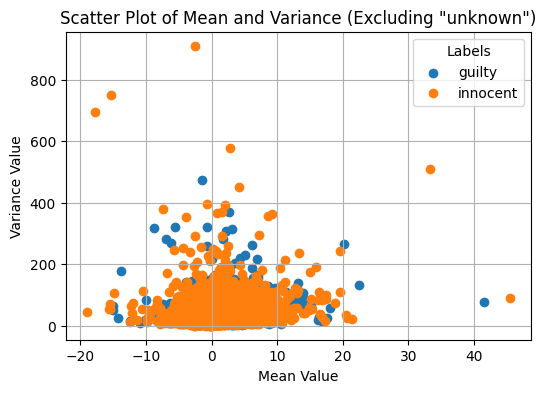

In [ ]:
plot_means_and_variance(df_2list[18])

In [ ]:
def plot_range_index_range(df):
    """
    Takes a DataFrame where each cell in the numeric columns contains lists of numbers.
    Computes the range (max - min) and the index range (index of max - index of min) for each row,
    removes rows with label 'unknown', and plots a scatter plot with color-coded remaining labels.

    Parameters:
    df (pd.DataFrame): DataFrame where each cell in the numeric columns is a list of numbers and the last column is labels.
    """
    # Check if the DataFrame is valid
    if df.empty or df.shape[1] < 2:
        raise ValueError("DataFrame must contain at least two columns (one for lists and one for labels).")

    # Extract labels column
    labels = df.iloc[:, -1]

    # Filter out rows where label is 'unknown'
    valid_df = df[labels != 'unknown']
    valid_labels = valid_df.iloc[:, -1]
    numeric_data = valid_df.iloc[:, :-1]

    # Initialize lists to store range and index ranges
    ranges = []
    index_ranges = []

    # Iterate over each row
    for index, row in numeric_data.iterrows():
        # Flatten the list if each cell is a list
        row_values = [item for sublist in row for item in (sublist if isinstance(sublist, list) else [sublist])]

        # Find min and max values
        min_value = np.min(row_values)
        max_value = np.max(row_values)

        # Find indices of min and max values
        min_index = row_values.index(min_value)
        max_index = row_values.index(max_value)

        # Calculate range and index range
        value_range = max_value - min_value
        index_range = max_index - min_index if max_index != min_index else 1  # To avoid division by zero

        # Calculate (max - min) / (index of max - index of min)
        range_index_range = value_range / index_range
        ranges.append(range_index_range)

    # Convert ranges to a pandas Series
    ranges_series = pd.Series(ranges, index=numeric_data.index)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))

    # Create a color map based on unique labels
    unique_labels = valid_labels.unique()
    color_map = plt.get_cmap('tab10')  # Use a colormap with enough distinct colors

    # Plot each label group with a different color
    for i, label in enumerate(unique_labels):
        subset_ranges = ranges_series[valid_labels == label]
        plt.scatter(subset_ranges.index, subset_ranges, color=color_map(i), label=label)

    # Add labels and legend
    plt.xlabel('Row Index')
    plt.ylabel('Range / Index Range')
    plt.title('Scatter Plot of Range / Index Range (Excluding "unknown")')
    plt.legend(title='Labels')
    plt.grid(True)
    plt.show()

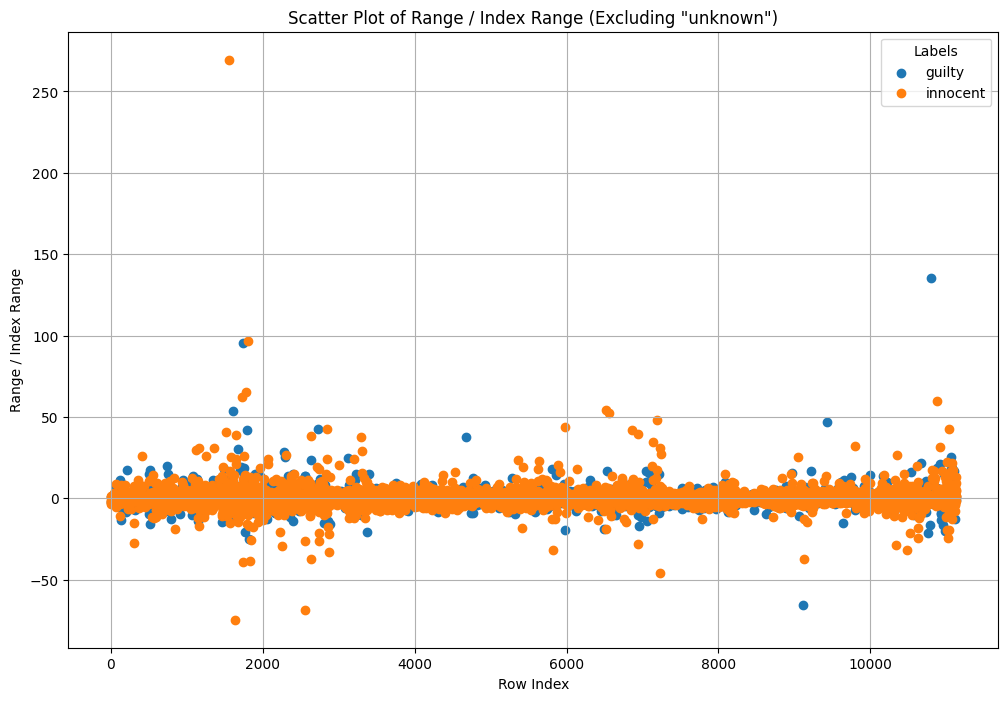

In [ ]:
plot_range_index_range(df_2list[0])

In [ ]:
def plot_max_index_range(df):
    """
    Takes a DataFrame where each cell in the numeric columns contains lists of numbers.
    Computes max / (index of max - index of min) for each row, removes rows with label 'unknown',
    and plots a scatter plot with color-coded remaining labels.

    Parameters:
    df (pd.DataFrame): DataFrame where each cell in the numeric columns is a list of numbers and the last column is labels.
    """
    # Check if the DataFrame is valid
    if df.empty or df.shape[1] < 2:
        raise ValueError("DataFrame must contain at least two columns (one for lists and one for labels).")

    # Extract labels column
    labels = df.iloc[:, -1]

    # Filter out rows where label is 'unknown'
    valid_df = df[labels != 'unknown']
    valid_labels = valid_df.iloc[:, -1]
    numeric_data = valid_df.iloc[:, :-1]

    # Initialize list to store the computed metrics
    max_index_ranges = []

    # Iterate over each row
    for index, row in numeric_data.iterrows():
        # Flatten the list if each cell is a list
        row_values = [item for sublist in row for item in (sublist if isinstance(sublist, list) else [sublist])]

        # Find max value and its index
        max_value = np.max(row_values)
        max_index = row_values.index(max_value)

        # Find min value and its index
        min_value = np.min(row_values)
        min_index = row_values.index(min_value)

        # Calculate max / (index of max - index of min)
        index_difference = max_index - min_index
        if index_difference == 0:  # Avoid division by zero
            index_difference = 1
        metric = max_value / index_difference
        max_index_ranges.append(metric)

    # Convert max_index_ranges to a pandas Series
    max_index_ranges_series = pd.Series(max_index_ranges, index=numeric_data.index)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))

    # Create a color map based on unique labels
    unique_labels = valid_labels.unique()
    color_map = plt.get_cmap('tab10')  # Use a colormap with enough distinct colors

    # Plot each label group with a different color
    for i, label in enumerate(unique_labels):
        subset_ranges = max_index_ranges_series[valid_labels == label]
        plt.scatter(subset_ranges.index, subset_ranges, color=color_map(i), label=label)

    # Add labels and legend
    plt.xlabel('Row Index')
    plt.ylabel('Max / (Index of Max - Index of Min)')
    plt.title('Scatter Plot of Max / (Index of Max - Index of Min) (Excluding "unknown")')
    plt.legend(title='Labels')
    plt.grid(True)
    plt.show()

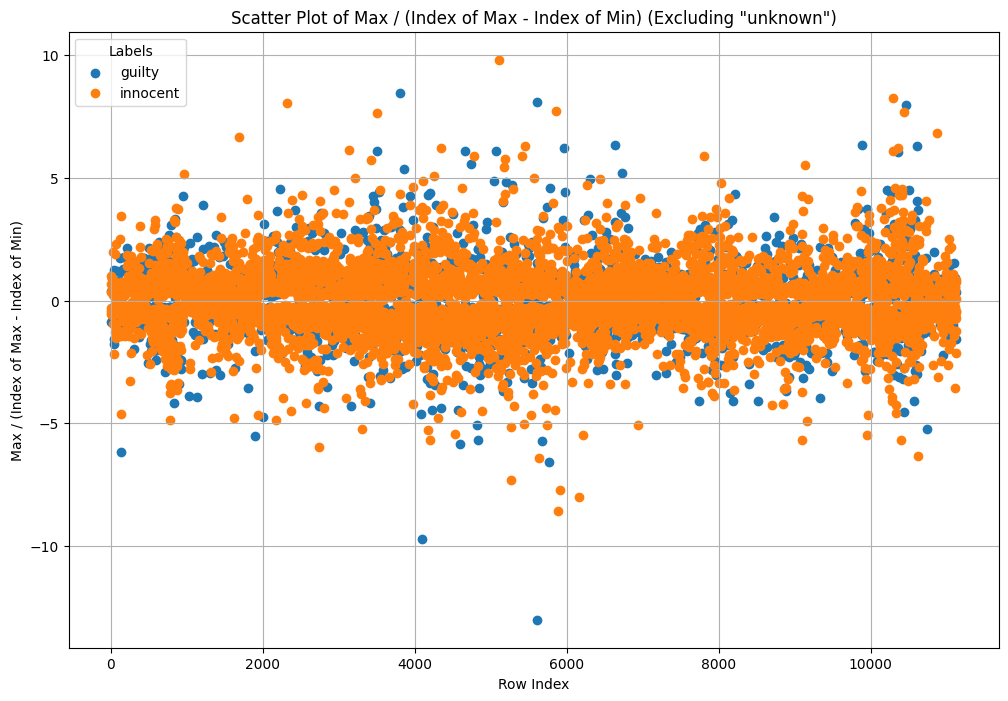

In [ ]:
plot_max_index_range(df_2list[20])

In [ ]:
def plot_eeg_signals_and_frequency_ranges(df):
    """
    Plots EEG signals from the dataframe and shows their frequency ranges.

    Parameters:
    df (pd.DataFrame): DataFrame with 'x' (list of EEG amplitudes) and 'y' (labels) columns.
    """
    # Define frequency bands
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 100)
    }

    # Loop through each row in the dataframe
    for index, row in df.iterrows():
        eeg_signal = np.array(row['x'])
        label = row['y']

        # Time vector (assuming uniform sampling rate; adjust if needed)
        fs = 1000  # Sampling frequency in Hz (adjust if necessary)
        N = len(eeg_signal)
        T = 1.0 / fs
        x = np.linspace(0.0, N*T, N, endpoint=False)

        # Plot the EEG signal
        plt.figure(figsize=(14, 6))

        # Plot EEG signal
        plt.subplot(2, 1, 1)
        plt.plot(x, eeg_signal)
        plt.title(f'EEG Signal for Label {label}')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')

        # Compute and plot the power spectral density
        plt.subplot(2, 1, 2)
        f, Pxx = welch(eeg_signal, fs, nperseg=1024)
        plt.semilogy(f, Pxx)
        plt.title('Power Spectral Density')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Power/Frequency [dB/Hz]')

        # Annotate frequency bands
        for band, (low, high) in bands.items():
            plt.axvline(x=low, color='r', linestyle='--')
            plt.axvline(x=high, color='r', linestyle='--')
            plt.text(low, max(Pxx) * 0.8, band, color='r')

        plt.tight_layout()
        plt.show()

        # Display the frequency ranges
        print(f"Frequency ranges for Label {label}:")
        for band, (low, high) in bands.items():
            print(f"{band}: {low} - {high} Hz")

In [ ]:
#plot_eeg_signals_and_frequency_ranges(df_2list[0])

In [ ]:
combined_dfs = []

for df in df_2list:
        # Apply wavelet transform to extract features
        wavelet_df = apply_wavelet_to_channel(df)
        # Apply bispectrum to extract features
        bispectrum_df = extract_bispectrum_features(df)

        # Combine wavelet and bispectrum features for this channel
        combined_df = pd.concat([wavelet_df.drop(columns='y'), bispectrum_df.drop(columns='y')], axis=1)
        combined_df['y'] = wavelet_df['y'].values  # Ensure labels are attached
        combined_dfs.append(combined_df)

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients w

In [ ]:
combined_dfs[20]

Alpha      Beta     Theta      Gamma          SLA         FOSM  \
0     -1.211829  0.180684 -0.107868  -4.765892  4414.758721  2296.142085   
1     -0.019679  0.136582 -0.862728   2.872907  4594.573860  2389.120708   
2     -0.252159  0.087373  0.045549 -10.367924  4795.873778  2518.550866   
3     -0.008869  0.155444 -0.378622 -13.981315  4488.022351  2244.191221   
4      0.631235  0.048796 -0.156277   2.336552  4346.063109  2195.955894   
...         ...       ...       ...        ...          ...          ...   
11124 -0.520367  0.026918  0.339304  -7.806452  2992.619911  1512.057810   
11125  0.149631  0.240250 -0.724047   3.265470  4390.731453  2163.115634   
11126  2.385813 -0.246258  0.127727   8.279912  4867.641890  2551.549765   
11127  0.150202 -0.116127  0.627845  -7.603492  4168.788965  2069.196484   
11128 -0.037354  0.015547 -0.015298  -4.743456  4771.125253  2404.222624   

              y  
0        guilty  
1      innocent  
2       unknown  
3      innocent  
4      innocent  
...         ...  
11124    guilty  
11125    guilty  
11126  innocent  
11127  innocent  
11128  innocent  

[11129 rows x 7 columns]

In [ ]:
channel=1
dataframe=combined_dfs[channel-1]
for feature in ['Alpha', 'Beta', 'Theta', 'SLA', 'FOSM']:
  print(feature)
  for specified_label in ['innocent', 'guilty']:
    print(specified_label,dataframe[dataframe['y'] == specified_label][feature].mean())

Alpha
innocent 0.05551554076520221
guilty 0.02400532811260244
Beta
innocent 0.0003274998006011823
guilty 0.00871422893999417
Theta
innocent -0.007516995794508523
guilty 0.005535309647227402
SLA
innocent 5388.306464984117
guilty 5366.383213729246
FOSM
innocent 2753.3692760545728
guilty 2741.8902870415327


In [ ]:
def scatter_plot_with_regression(df, feature_x, feature_y, label_column='y'):
    """
    Plots a scatter plot with regression line/plane for the given features in the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - feature_x: string, name of the feature for the x-axis.
    - feature_y: string, name of the feature for the y-axis.
    - label_column: string, name of the column containing labels for color coding. Default is 'y'.
    """
    unique_labels = df[label_column].unique()
    unique_labels=[label for label in unique_labels if label!='unknown']
    # Create a scatter plot
    plt.figure(figsize=(10, 6))

    # Plot scatter plot color-coded by labels
    sns.scatterplot(data=df[df['y'] != 'unknown'], x=feature_x, y=feature_y, hue=label_column, palette='viridis', s=100, alpha=0.7, edgecolor='k')

    # Add regression line
    sns.regplot(x=feature_x, y=feature_y, data=df[df['y'] != 'unknown'], scatter=False, color='red', line_kws={"linewidth": 2})

    plt.title(f'Scatter Plot of {feature_x} vs {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(title=label_column)
    plt.show()


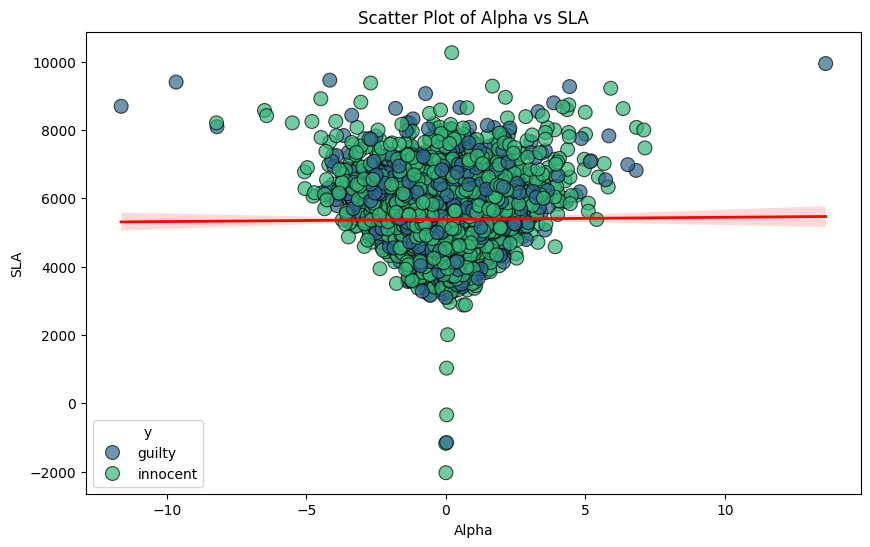

In [ ]:
scatter_plot_with_regression(combined_dfs[0], 'Alpha', 'SLA')

In [ ]:
def visualize_dataframe_with_subplots(df, label_col):
    """
    Visualizes the combinations of features and labels in the DataFrame using subplots.

    Parameters:
    df (pd.DataFrame): The DataFrame containing features and label columns.
    label_col (str): The name of the column containing multiple labels.
    """
    # Get feature columns dynamically by excluding the label column
    feature_cols = [col for col in df.columns if col != label_col]

    # Number of features
    n_features = len(feature_cols)

    # Ensure the DataFrame contains the expected columns
    if label_col not in df.columns:
        raise KeyError(f"Label column '{label_col}' not found in DataFrame. Available columns: {df.columns.tolist()}")
    if n_features < 1:
        raise ValueError("No feature columns found. Ensure the DataFrame has at least one feature column.")

    # Debugging information
    print(f"Feature columns: {feature_cols}")
    print(f"Label column: {label_col}")
    print(f"Total features: {n_features}")

    # Set up the figure for subplots with dynamic grid size
    fig, axes = plt.subplots(nrows=n_features, ncols=n_features, figsize=(4 * n_features, 4 * n_features))

    # Iterate over combinations of features for plotting
    for i, feature1 in enumerate(feature_cols):
        for j, feature2 in enumerate(feature_cols):
            ax = axes[i, j]
            if i == j:
                # Diagonal: Plot distribution of a single feature
                sns.histplot(df, x=feature1, ax=ax, kde=True, hue=label_col, palette='viridis', element='step')
                ax.set_ylabel('Frequency')
            else:
                # Off-diagonal: Scatter plot of feature pairs
                sns.scatterplot(data=df, x=feature1, y=feature2, hue=label_col, palette='viridis', ax=ax, legend=(i == 0 and j == n_features-1))
            ax.set_xlabel(feature1)
            ax.set_ylabel(feature2)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


In [ ]:
combined_dfs[0].columns[:-1].tolist()

['Alpha', 'Beta', 'Theta', 'Gamma', 'SLA', 'FOSM']

In [ ]:
df = df_2list[0]
# Calculate mean of lists in column 'x'
df['mean'] = df['x'].apply(lambda lst: np.mean(lst) if isinstance(lst, list) else np.nan)

df['mean']

0       -0.555242
1       -3.066185
2        0.679655
3       -6.092784
4       -2.073738
           ...   
11124    0.189765
11125   -9.587419
11126   -0.214664
11127    1.837429
11128    0.549615
Name: mean, Length: 11129, dtype: float64

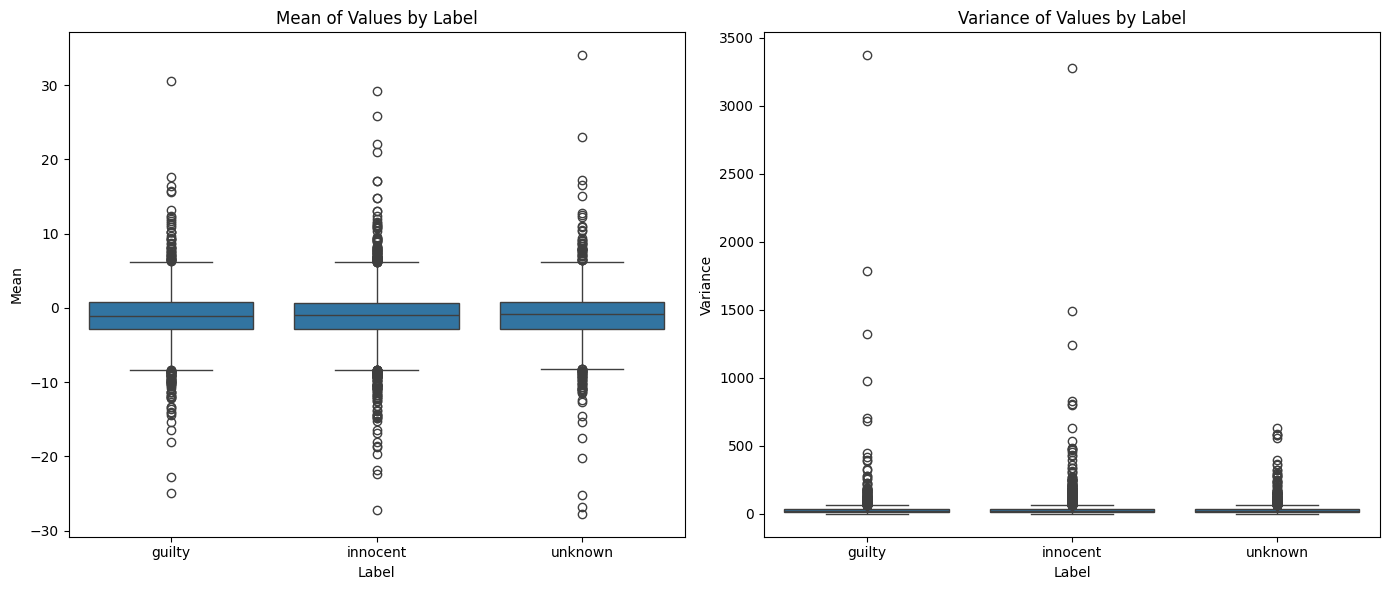

In [ ]:
def visualize_combinations(df):
    """
    Visualize the combinations of mean and variance with respect to the label column 'y'.

    Parameters:
    df (DataFrame): DataFrame containing 'mean', 'variance', and 'y' columns.
    """
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot mean
    sns.boxplot(x='y', y='mean', data=df, ax=axes[0])
    axes[0].set_title('Mean of Values by Label')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Mean')

    # Plot variance
    sns.boxplot(x='y', y='variance', data=df, ax=axes[1])
    axes[1].set_title('Variance of Values by Label')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Variance')

    plt.tight_layout()
    plt.show()

df = df_2list[0]

# Calculate mean and variance of lists in column 'x'
df['mean'] = df['x'].apply(lambda lst: np.mean(lst) if isinstance(lst, list) else np.nan)
df['variance'] = df['x'].apply(lambda lst: np.var(lst) if isinstance(lst, list) else np.nan)

visualize_combinations(df_2list[0])

Feature columns: ['Alpha', 'Beta', 'Theta', 'Gamma', 'SLA', 'FOSM']
Label column: y
Total features: 6


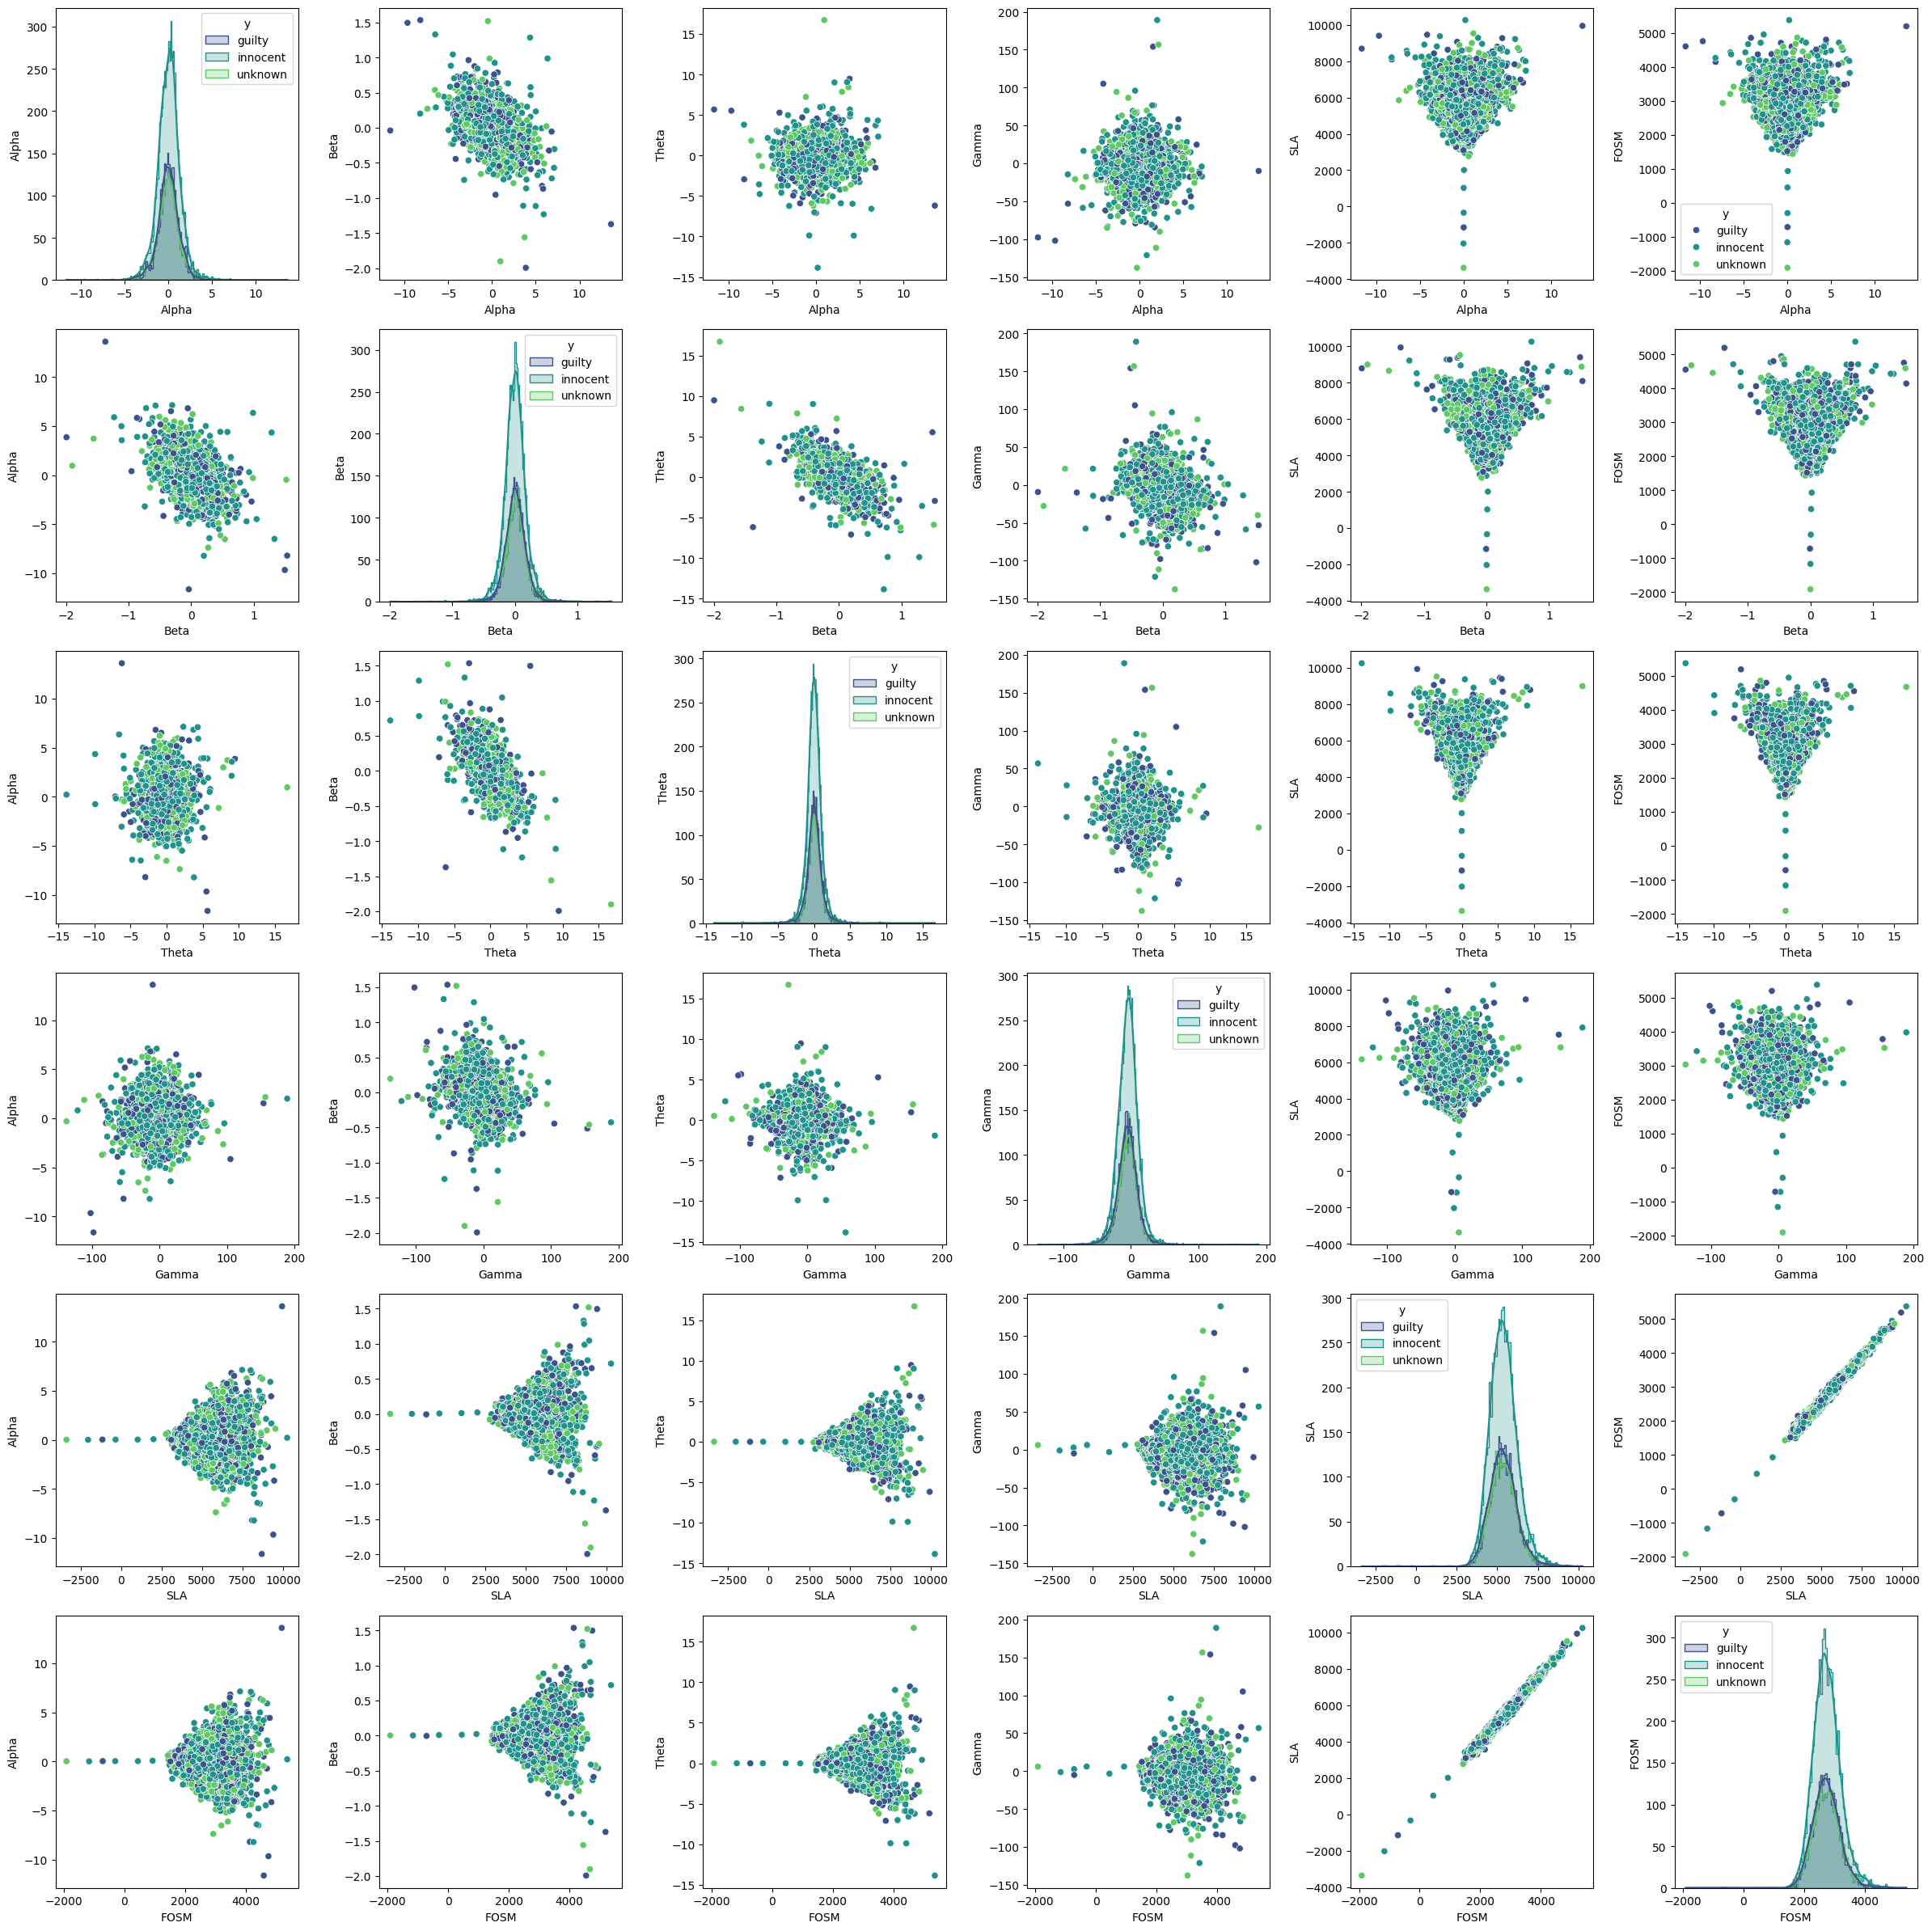

In [ ]:
visualize_dataframe_with_subplots(combined_dfs[0], 'y')

# new pipeline

In [ ]:
import numpy as np
import pandas as pd
import re
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle

# Convert string to array
def convert_string_to_array(value):
    """Convert a string representation of numbers to a numpy array."""
    if isinstance(value, str):
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", value)
        return np.array(numbers, dtype=np.float64)
    else:
        print(f"Expected string, got {type(value)}")
        return np.array([])  # Return empty array if conversion fails

# Calculate bispectrum
def bispectrum(signal, fs=1.0, nfft=None):
    """Calculate the bispectrum of a signal."""
    n = len(signal)
    if nfft is None:
        nfft = n
    X = fft(signal, nfft)
    B = np.zeros((nfft, nfft), dtype=complex)
    for f1 in range(nfft):
        for f2 in range(nfft):
            f3 = (f1 + f2) % nfft
            B[f1, f2] = X[f1] * X[f2] * np.conj(X[f3])
    return B

# Extract bispectrum features from a DataFrame
def extract_bispectrum_features(df, fs=1.0, nfft=None):
    """Extract bispectrum features from each signal in the DataFrame."""
    features = []
    for _, row in df.iterrows():
        signal = convert_string_to_array(row['x'])
        if signal.size == 0:
            print(f"Skipping row due to invalid signal data: {row['x']}")
            continue

        B = bispectrum(signal, fs=fs, nfft=nfft)

        # Calculate features from the bispectrum
        mean_value = np.mean(B)
        var_value = np.var(B)
        skew_value = skew(np.real(B.flatten()))
        kurtosis_value = kurtosis(np.real(B.flatten()))

        features.append({
            'mean': mean_value,
            'variance': var_value,
            'skewness': skew_value,
            'kurtosis': kurtosis_value,
            'y': row['y']
        })
    return pd.DataFrame(features)

def feature_selection(combined_dfs):
    """Calculate F-scores for feature selection."""
    f_scores = []
    for combined_df in combined_dfs:
        features = combined_df.drop(columns='y').values
        labels = combined_df['y'].values
        _, p_values = f_classif(features, labels)
        f_scores.append(np.mean(p_values))
    return np.array(f_scores)

def extract_top_features(combined_dfs, f_scores, top_n=4):
    """Extract features from top_n features based on F-scores."""
    top_indices = np.argsort(f_scores)[:top_n]
    all_features, all_labels = [], []

    for idx in top_indices:
        df = combined_dfs[idx]
        X = df.drop(columns='y').values
        y = df['y'].values
        all_features.append(X)
        all_labels.append(y)

    X_combined = np.vstack(all_features)
    y_combined = np.hstack(all_labels)
    return X_combined, y_combined

def classify_with_svm(X, y, n_splits=10):
    """Classify using SVM and return the results."""
    results = []
    unique_labels = np.unique(y)

    for i, label1 in enumerate(unique_labels):
        for label2 in unique_labels[i + 1:]:
            mask = (y == label1) | (y == label2)
            X_comb, y_comb = X[mask], y[mask]
            y_comb_numeric = np.where(y_comb == label1, 0, 1)

            # Balance training samples
            X_comb, y_comb = shuffle(X_comb, y_comb, random_state=42)
            class_counts = np.bincount(y_comb_numeric)
            min_count = np.min(class_counts)
            balanced_indices = np.hstack([
                np.where(y_comb_numeric == i)[0][:min_count] for i in np.unique(y_comb_numeric)
            ])
            X_comb_balanced = X_comb[balanced_indices]
            y_comb_balanced = y_comb_numeric[balanced_indices]

            accuracies, sensitivities, specificities = [], [], []

            skf = StratifiedKFold(n_splits=n_splits)
            for train_index, test_index in skf.split(X_comb_balanced, y_comb_balanced):
                X_train, X_test = X_comb_balanced[train_index], X_comb_balanced[test_index]
                y_train, y_test = y_comb_balanced[train_index], y_comb_balanced[test_index]

                clf = SVC(kernel='rbf')
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

                accuracies.append(accuracy_score(y_test, y_pred))
                conf_matrix = confusion_matrix(y_test, y_pred)
                sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
                specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
                sensitivities.append(sensitivity)
                specificities.append(specificity)

            results.append({
                'label_pair': f"{label1} vs {label2}",
                'accuracy': np.mean(accuracies),
                'sensitivity': np.mean(sensitivities),
                'specificity': np.mean(specificities),
            })

    return pd.DataFrame(results)

def process_channel_dataframes(dataframes, n_channels_list):
    """Process channel dataframes, extract features, and classify."""
    results = {}

    for top_n in n_channels_list:
        combined_dfs = []

        for df in dataframes:
            bispectrum_df = extract_bispectrum_features(df)
            combined_df = bispectrum_df
            combined_dfs.append(combined_df)

        f_scores = feature_selection(combined_dfs)
        X_combined, y_combined = extract_top_features(combined_dfs, f_scores, top_n)
        results[top_n] = classify_with_svm(X_combined, y_combined)

    return results


In [10]:
len(df_2list)

NameError: name 'df_2list' is not defined

In [ ]:

n_channels_list = [2, 4, 8, 16]
results = process_channel_dataframes(df_2list, n_channels_list)

print("Results DataFrame:")
print(results)
print("Results DataFrame:")
for top_n, result_df in results.items():
    print(f"Results for top {top_n} channels:")
    print(result_df)

In [ ]:
df_2list[0]

x         y      mean  \
0      [-2.350524425506592, -0.7570440173149109, -2.3...    guilty -0.555242   
1      [-5.394754409790039, -9.951990127563477, -7.31...  innocent -3.066185   
2      [5.784703731536865, 7.869145393371582, 4.66007...   unknown  0.679655   
3      [5.334604263305664, 2.395622968673706, -2.9817...  innocent -6.092784   
4      [-0.3211749494075775, 0.6568494439125061, 4.31...  innocent -2.073738   
...                                                  ...       ...       ...   
11124  [-4.202564239501953, 6.2010297775268555, 2.753...    guilty  0.189765   
11125  [-22.393402099609375, -13.479719161987305, -7....    guilty -9.587419   
11126  [-0.2879485785961151, -5.510219573974609, 5.68...  innocent -0.214664   
11127  [-2.0886240005493164, -1.0878431797027588, 6.2...  innocent  1.837429   
11128  [6.082340240478516, 4.30152702331543, 0.086145...  innocent  0.549615   

         variance  
0        8.186590  
1       13.659901  
2      111.265214  
3       29.282305  
4       39.155577  
...           ...  
11124   19.141109  
11125   41.529061  
11126   20.145199  
11127   25.146906  
11128   20.335443  

[11129 rows x 4 columns]

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from numpy.fft import fft, ifft

def compute_bispectrum(x, segment_length=1, overlap=0.5, fs=1.0):
    """Compute bispectrum of EEG data.

    Args:
        x (array-like): Array of EEG values.
        segment_length (int): Length of each segment in seconds.
        overlap (float): Overlap between segments in seconds.
        fs (float): Sampling frequency.

    Returns:
        bispectrum (ndarray): Computed bispectrum.
    """
    segment_samples = int(segment_length * fs)
    overlap_samples = int(overlap * fs)
    step_samples = segment_samples - overlap_samples
    n_segments = (len(x) - overlap_samples) // step_samples

    bispectrum_sum = np.zeros((segment_samples, segment_samples), dtype=complex)

    for i in range(n_segments):
        start = i * step_samples
        end = start + segment_samples
        segment = x[start:end]

        # Compute third-order cumulant
        C3_x = np.zeros((segment_samples, segment_samples), dtype=complex)
        for n1 in range(segment_samples):
            for n2 in range(segment_samples):
                C3_x[n1, n2] = np.mean(np.conj(segment[n1:]) * segment[n1:] * segment[n2:])

        # Compute bispectrum via Fourier transform
        B_x = np.fft.fftshift(np.fft.fft2(C3_x))
        bispectrum_sum += np.abs(B_x)

    return bispectrum_sum / n_segments

def extract_features(bispectrum):
    """Extract mean, variance, skewness, and kurtosis from bispectrum.

    Args:
        bispectrum (ndarray): Computed bispectrum.

    Returns:
        features (dict): Dictionary with extracted features.
    """
    bispectrum_flat = bispectrum.flatten()

    features = {
        'mean': np.mean(bispectrum_flat),
        'variance': np.var(bispectrum_flat),
        'skewness': skew(bispectrum_flat),
        'kurtosis': kurtosis(bispectrum_flat)
    }

    return features

def process_dataframe(df, segment_length=1, overlap=0.5, fs=1.0):
    """Process DataFrame to compute bispectrum features.

    Args:
        df (DataFrame): DataFrame with columns 'x' (EEG values) and 'y' (labels).
        segment_length (int): Length of each segment in seconds.
        overlap (float): Overlap between segments in seconds.
        fs (float): Sampling frequency.

    Returns:
        result_df (DataFrame): DataFrame with features and labels.
    """
    results = []

    for _, row in df.iterrows():
        eeg_values = np.array(row['x'])
        label = row['y']

        bispectrum = compute_bispectrum(eeg_values, segment_length, overlap, fs)
        features = extract_features(bispectrum)

        results.append({**features, 'y': label})

    result_df = pd.DataFrame(results)
    return result_df


In [ ]:
result_df = process_dataframe(df)
print(result_df)

In [25]:
import numpy as np
import pandas as pd
import re
from scipy.fft import fft2
from scipy.stats import skew, kurtosis

# Convert string to array (as provided)
def convert_string_to_array(string):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", string)
    return np.array(numbers, dtype=np.float64)

def compute_third_order_cumulant(signal_segment):
    N = len(signal_segment)
    C3 = np.zeros((N, N), dtype=np.complex128)

    for n1 in range(N):
        for n2 in range(N):
            C3[n1, n2] = np.mean(signal_segment * np.roll(signal_segment, n1) * np.roll(signal_segment, n2))

    return C3

def compute_bispectrum(C3):
    return fft2(C3)

def extract_statistical_features(bispectrum):
    T1, T2 = bispectrum.shape
    bispectrum_flat = np.abs(bispectrum).flatten()

    mean_bispectrum = np.mean(bispectrum_flat)
    variance_bispectrum = np.var(bispectrum_flat)
    skewness_bispectrum = skew(bispectrum_flat)
    kurtosis_bispectrum = kurtosis(bispectrum_flat)

    return mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum

def bispectrum_feature_extraction(df, segment_length=26, overlap=0, fs=1):
    data = []

    segment_samples = segment_length
    overlap_samples = overlap

    #print("Segment samples:", segment_samples)
    #print("Overlap samples:", overlap_samples)

    for index, row in df.iterrows():
        eeg_signal = np.array(row['x'])  # Convert the list of EEG values to a numpy array
        label = row['y']  # Label is a string

        #print(f"\nProcessing row {index} with label: {label}")
        #print("EEG signal length:", len(eeg_signal))

        if len(eeg_signal) < segment_samples:
            print(f"EEG signal length ({len(eeg_signal)}) is shorter than the segment length ({segment_samples}).")
            continue

        # Use full signal as segment if shorter than segment length
        start = 0
        while start + segment_samples <= len(eeg_signal):
            segment = eeg_signal[start:start + segment_samples]

            #print(f"Segment start index: {start}, end index: {start + segment_samples}")
            #print("Segment length:", len(segment))

            # Compute the third-order cumulant and bispectrum
            C3 = compute_third_order_cumulant(segment)
            bispectrum = compute_bispectrum(C3)

            #print("C3 shape:", C3.shape)
            #print("Bispectrum shape:", bispectrum.shape)

            # Extract statistical features
            mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum = extract_statistical_features(bispectrum)

            #print("Mean of bispectrum:", mean_bispectrum)
            #print("Variance of bispectrum:", variance_bispectrum)
            #print("Skewness of bispectrum:", skewness_bispectrum)
            #print("Kurtosis of bispectrum:", kurtosis_bispectrum)

            # Append features and label to the data list
            data.append([mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum, label])

            start += segment_samples - overlap_samples

        #print(f"Total segments for row {index}: {len(data)}")

    # Create a DataFrame from the extracted features
    features_df = pd.DataFrame(data, columns=['mean', 'variance', 'skewness', 'kurtosis', 'y'])

    print("\nFeatures DataFrame:")
    print(features_df.head())
    #print("Total segments processed:", len(features_df))

    return features_df

In [ ]:
bs=bispectrum_feature_extraction(df_2list[20])
bs

In [ ]:
# Test compute_third_order_cumulant
test_signal = np.array([1, 2, 3, 4, 5])
C3 = compute_third_order_cumulant(test_signal)
print("Test C3 shape:", C3.shape)

# Test compute_bispectrum
test_bispectrum = compute_bispectrum(C3)
print("Test Bispectrum shape:", test_bispectrum.shape)

# Test extract_statistical_features
mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum = extract_statistical_features(test_bispectrum)
print("Mean:", mean_bispectrum)
print("Variance:", variance_bispectrum)
print("Skewness:", skewness_bispectrum)
print("Kurtosis:", kurtosis_bispectrum)

Test C3 shape: (5, 5)
Test Bispectrum shape: (5, 5)
Mean: 48.69322024461031
Variance: 16693.970302209873
Skewness: 4.538140266700663
Kurtosis: 19.090032540772917


In [22]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#from mne.decoding import CSP
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix


# Step 2: Use CSP to rank channels
def rank_channels_csp(eeg_data, labels):
    csp = CSP(n_components=4, log=True)
    csp.fit(eeg_data, labels)
    return csp

# Step 3: SVM Classification using selected channels with 10-fold cross-validation
def svm_classification(features, labels):
    skf = StratifiedKFold(n_splits=10)
    accuracies = []
    sensitivities = []
    specificities = []

    for fold, (train_index, test_index) in enumerate(skf.split(features, labels)):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Balance the training samples
        class_counts = np.bincount(y_train)
        min_class_count = class_counts.min()
        balanced_train_indices = []

        for label in np.unique(y_train):
            label_indices = np.where(y_train == label)[0]
            np.random.shuffle(label_indices)
            balanced_train_indices.extend(label_indices[:min_class_count])

        X_train_balanced = X_train[balanced_train_indices]
        y_train_balanced = y_train[balanced_train_indices]

        # Standardize the data and fit SVM
        clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1))
        clf.fit(X_train_balanced, y_train_balanced)

        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred, average='weighted')

        # Calculate specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)  # True Negative Rate

        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

        print(f"Fold {fold + 1}:")
        print(f"Training samples: {len(balanced_train_indices)}, Testing samples: {len(test_index)}")
        print(f"Training samples per class: {min_class_count} each")

    # Compute mean and variance
    mean_accuracy = np.mean(accuracies)
    accuracy_variance = np.var(accuracies)
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    results = {
        'Accuracy': mean_accuracy,
        'Accuracy Variance': accuracy_variance,
        'Sensitivity': mean_sensitivity,
        'Specificity': mean_specificity
    }

    return results

# Step 4: Process EEG data
def process_eeg(dataframes, labels):
    all_features = []
    for df in dataframes:
        features_df = bispectrum_feature_extraction(df)
        all_features.append(features_df)

    # Stack features for CSP analysis
    combined_features = np.vstack([f.values for f in all_features])
    combined_labels = np.array(labels)

    csp = rank_channels_csp(combined_features, combined_labels)

    selected_channels = np.concatenate((csp.filters_[:2], csp.filters_[-2:]))
    combined_features_selected = combined_features @ selected_channels.T

    print(f"Selected channels: {selected_channels}")

    # Perform SVM classification with cross-validation
    results = svm_classification(combined_features_selected, combined_labels)

    results_df = pd.DataFrame([results])

    return results_df

# Example usage (assuming 'dataframes' is a list of EEG dataframes and 'labels' is a list of corresponding labels for channels)
# results_df = process_eeg(dataframes, labels)
# print(results_df)


In [ ]:
results_df = process_eeg(df_2list[:6], labels)

In [ ]:
print(results_df)